In [1]:
%%capture
%matplotlib inline
!pip install optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, string, time, math
import optuna
from   datetime import date

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing  import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition  import PCA
from sklearn.impute         import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline      import Pipeline, make_pipeline
from scipy.stats            import wilcoxon
from statistics             import mean

from sklearn.ensemble     import StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.svm          import SVC, LinearSVC
from sklearn.naive_bayes  import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.tree         import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.neural_network           import MLPClassifier
from sklearn.gaussian_process         import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.discriminant_analysis    import LinearDiscriminantAnalysis

from sklearn.metrics           import make_scorer, accuracy_score, f1_score, roc_curve, roc_auc_score, auc, brier_score_loss, confusion_matrix, matthews_corrcoef
from sklearn.model_selection   import cross_validate, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
smells = ['[J] God Class.csv', '[J] Data Class.csv', '[J] Long Method.csv', '[J] Long Parameter List.csv', '[J] Feature Envy.csv', '[J] Switch Statements.csv' ,
         '[P] Large Class.csv', '[P] Long Method.csv']

defect = ['KC1.csv', 'JM1.csv', 'PC5.csv', 'Debug.csv',
          'SWT.csv', 'Mylyn.csv', 'Eclipse PDE UI.csv', 'Eclipse JDT Core.csv',
          'Eclipse 2.0.csv', 'Eclipse 2.1.csv', 'Eclipse 3.0.csv',
          'Camel 1.2.csv', 'Xalan 2.5.csv', 'Xalan 2.6.csv', 'Lucene 2.4.csv',
          'Prop 1.csv', 'Prop 2.csv', 'Prop 3.csv', 'Prop 4.csv', 'Prop 5.csv', 'Prop 43.csv']

tmp = ['[J] God Class.csv']

fnames = smells

models = {
    'KNN' : KNeighborsClassifier(),
    'DT'  : DecisionTreeClassifier(),
    'LR'  : LogisticRegression(solver='liblinear',max_iter=500),
    'SVM' : SVC(probability=True),
    'MLP' : MLPClassifier(max_iter=500),
    'NB'  : BernoulliNB(),
}

DetDF = pd.DataFrame (columns = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Brier', 'AUC', 'MCC', 'Time', 'Dataset'])
ResDF = pd.DataFrame (columns = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Brier', 'AUC', 'MCC', 'Time', 'Dataset'])
StaDF = pd.DataFrame (columns = ['Classifier_1', 'Classifier_2', 'Test', 'Stat', 'Sig-level', 'p-value', 'Null Hypo', 'Win', 'Lost', 'Effect Size', 'Effect Type', 'Dataset', 'Metric'])

# **Results analysis**

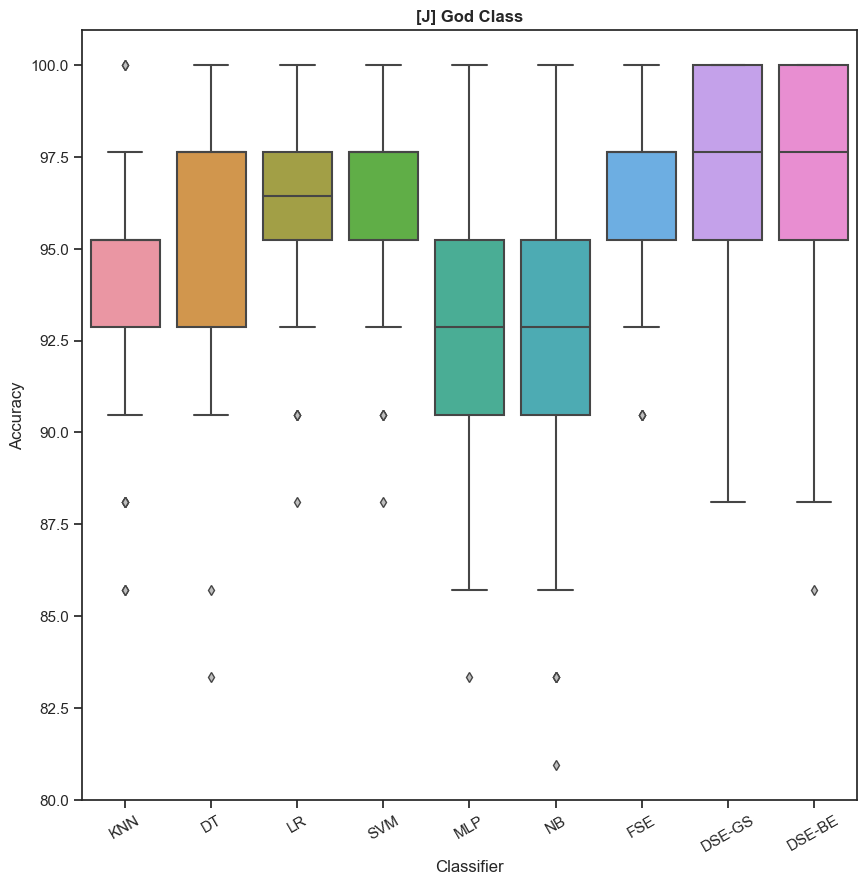

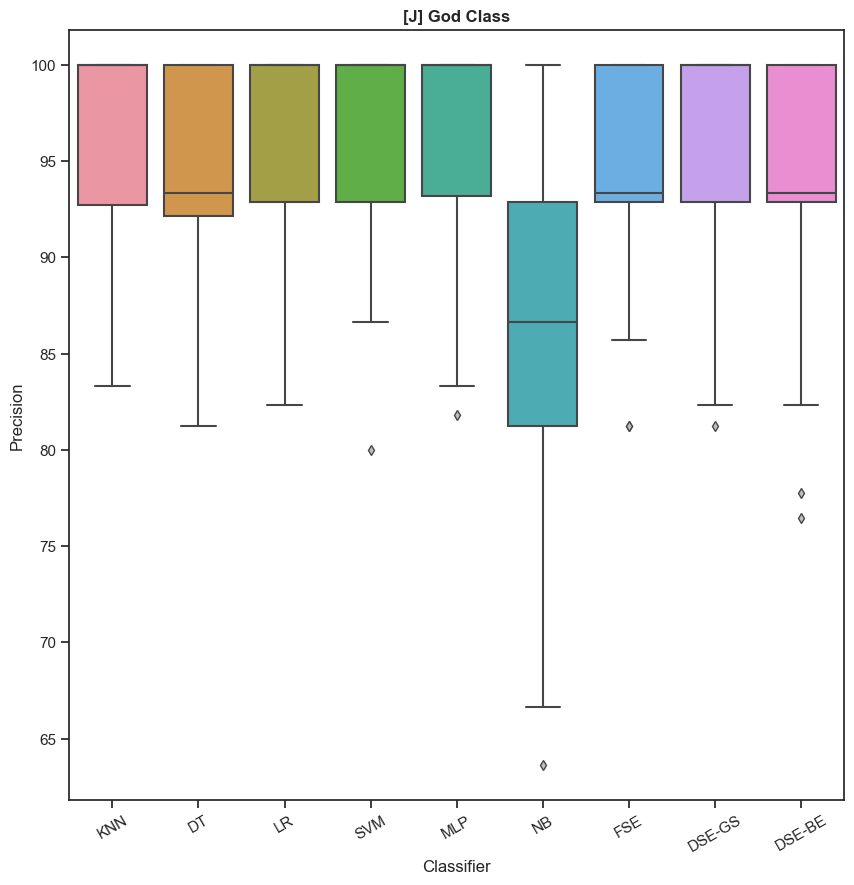

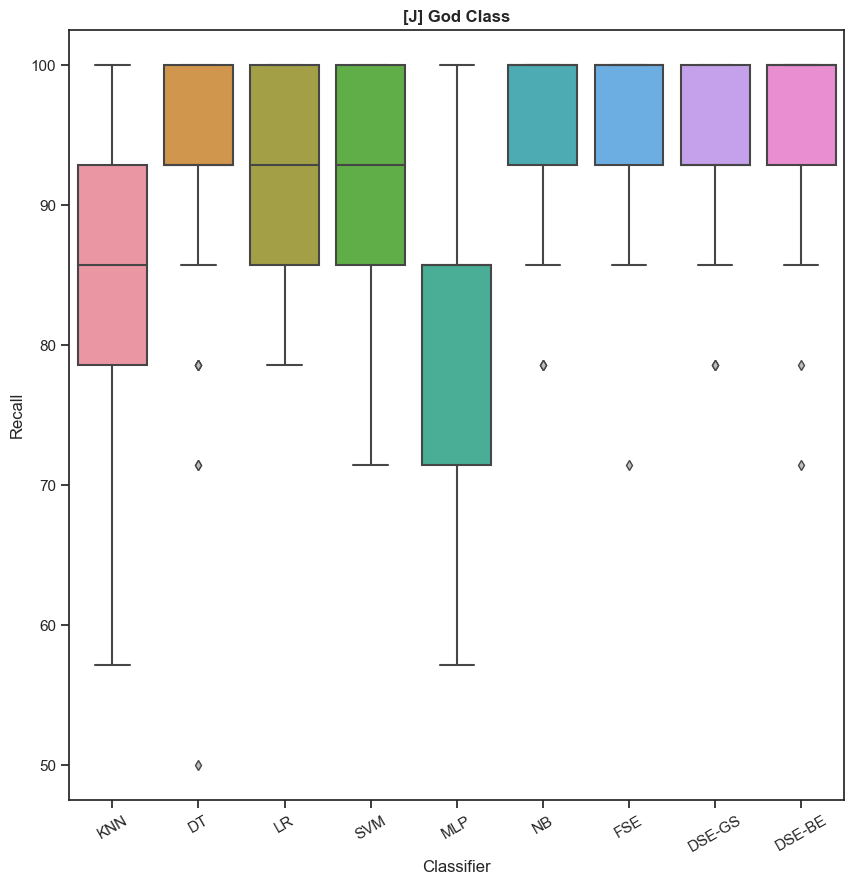

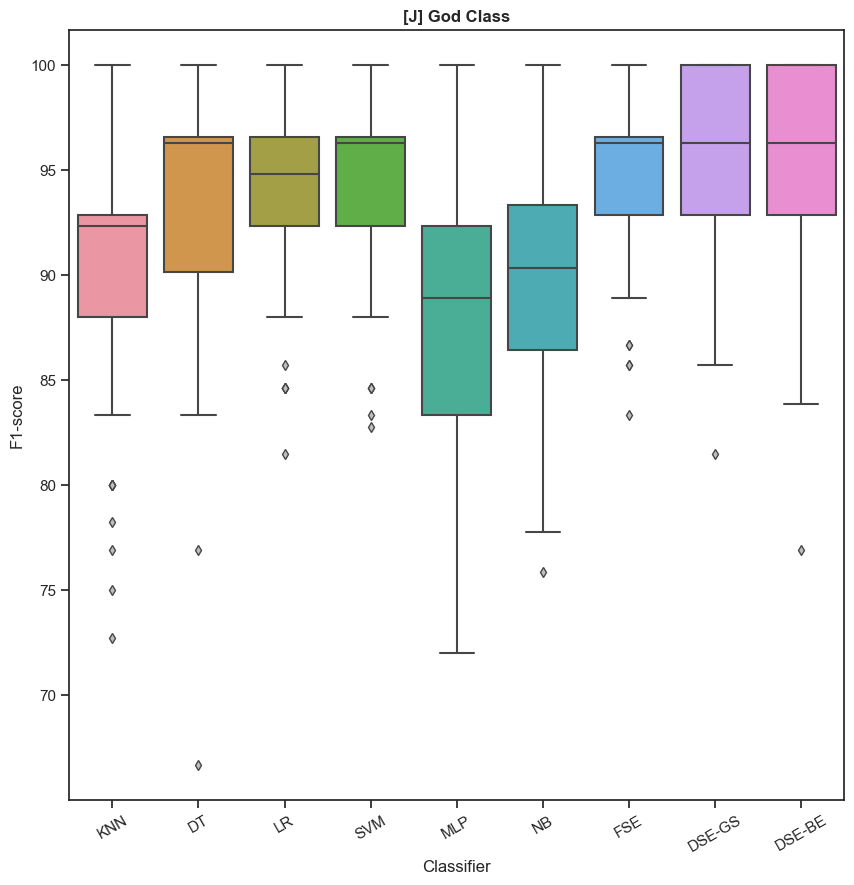

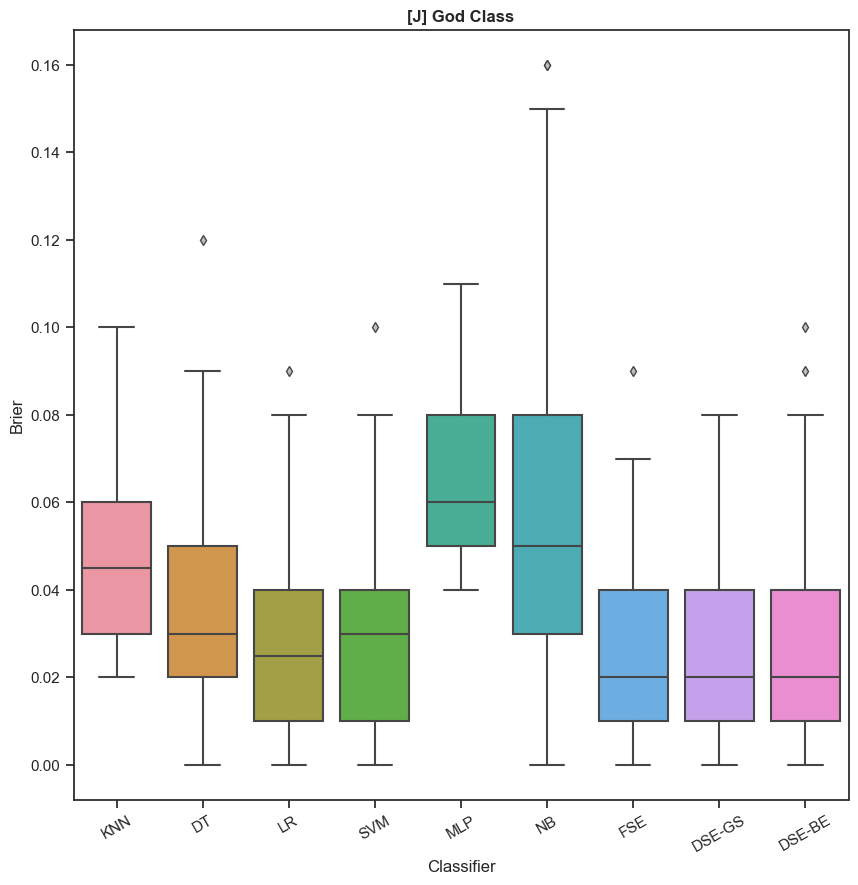

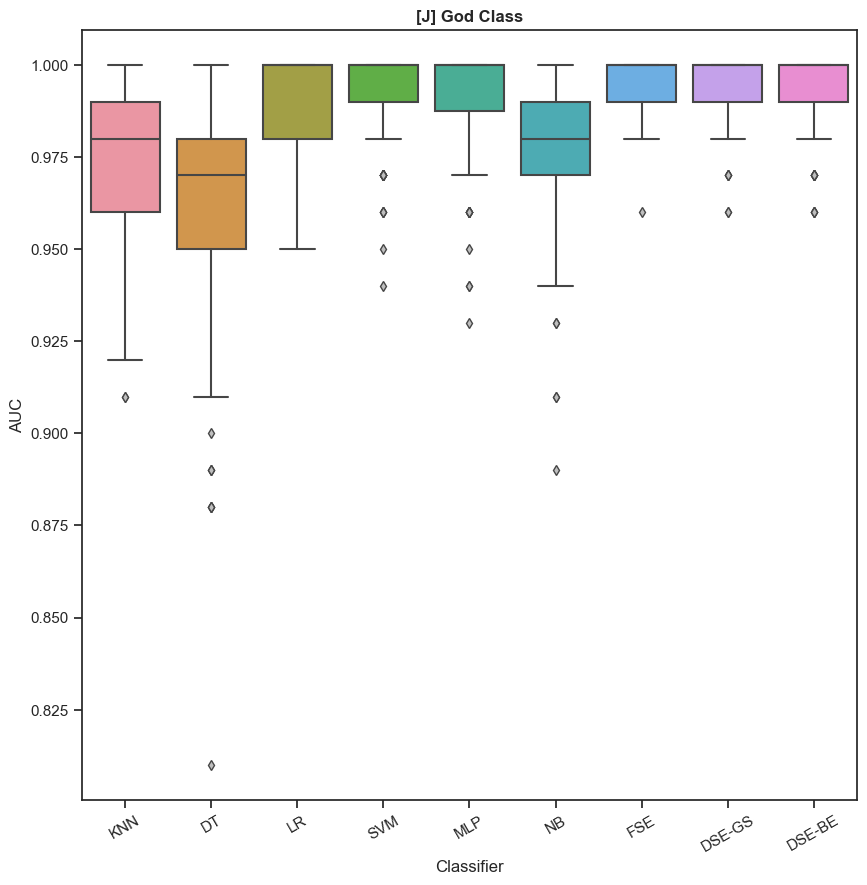

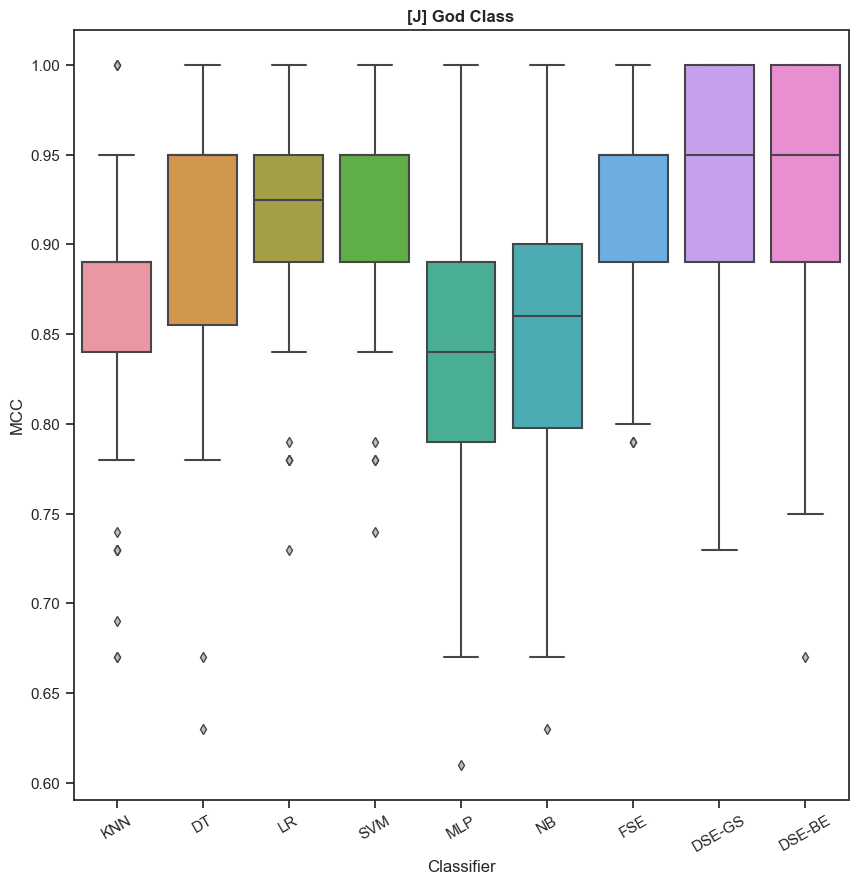

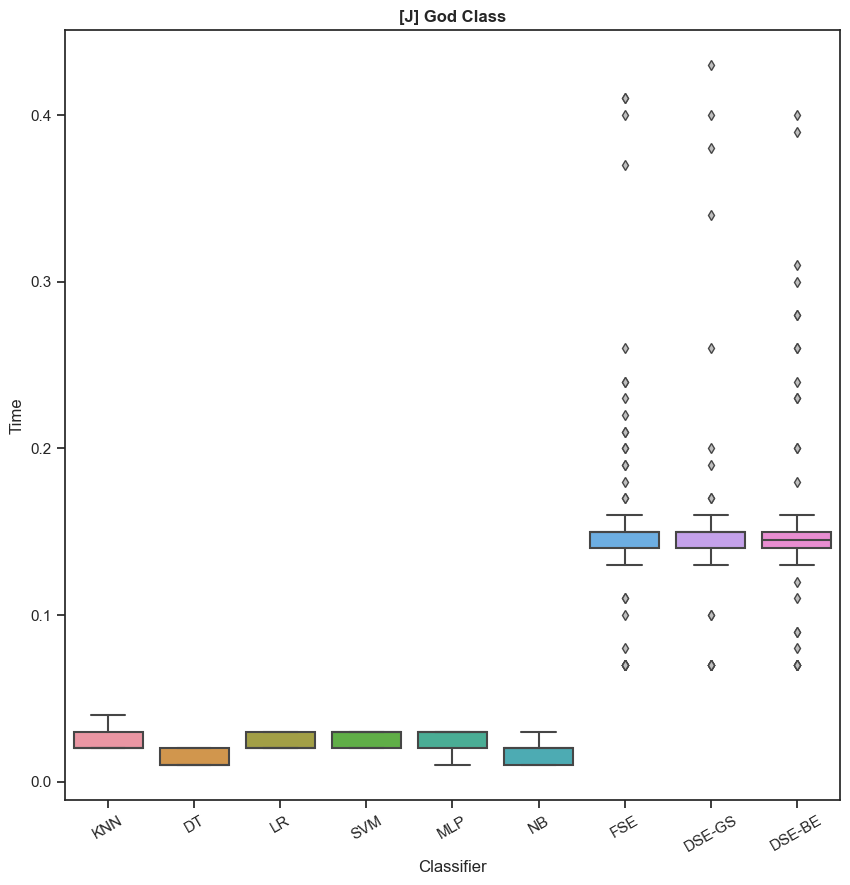

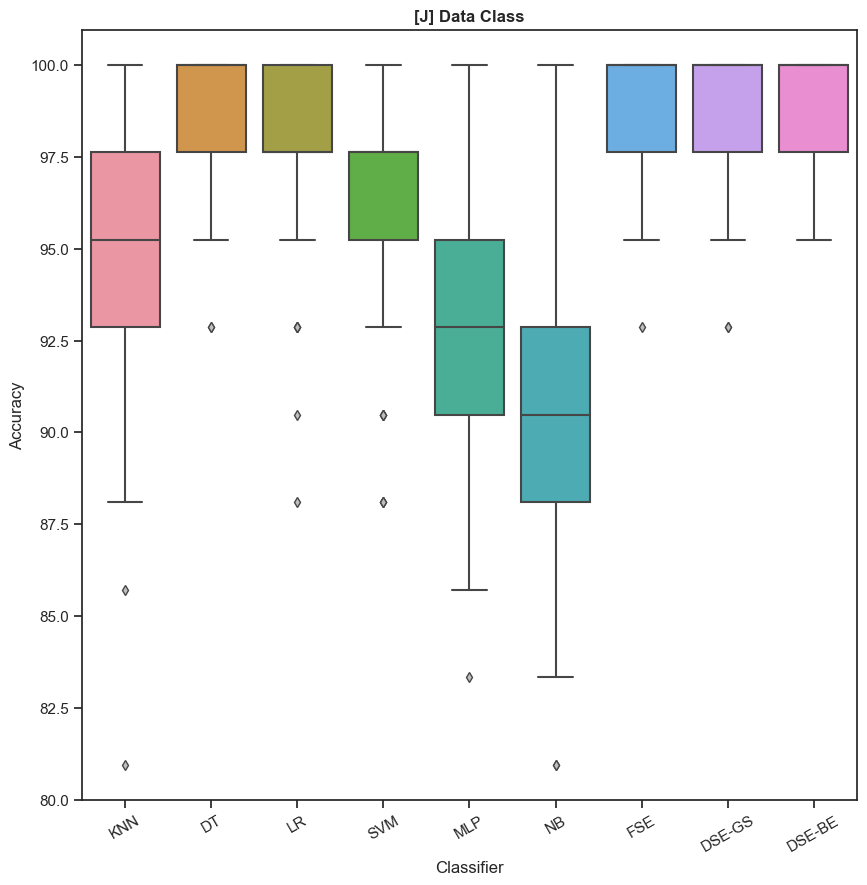

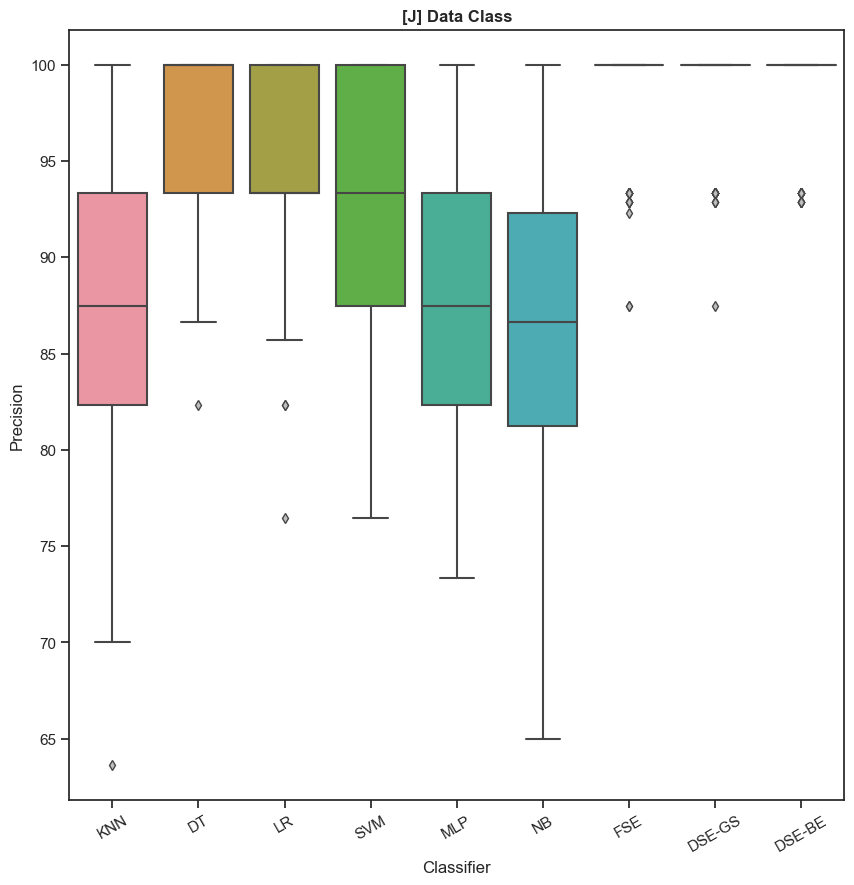

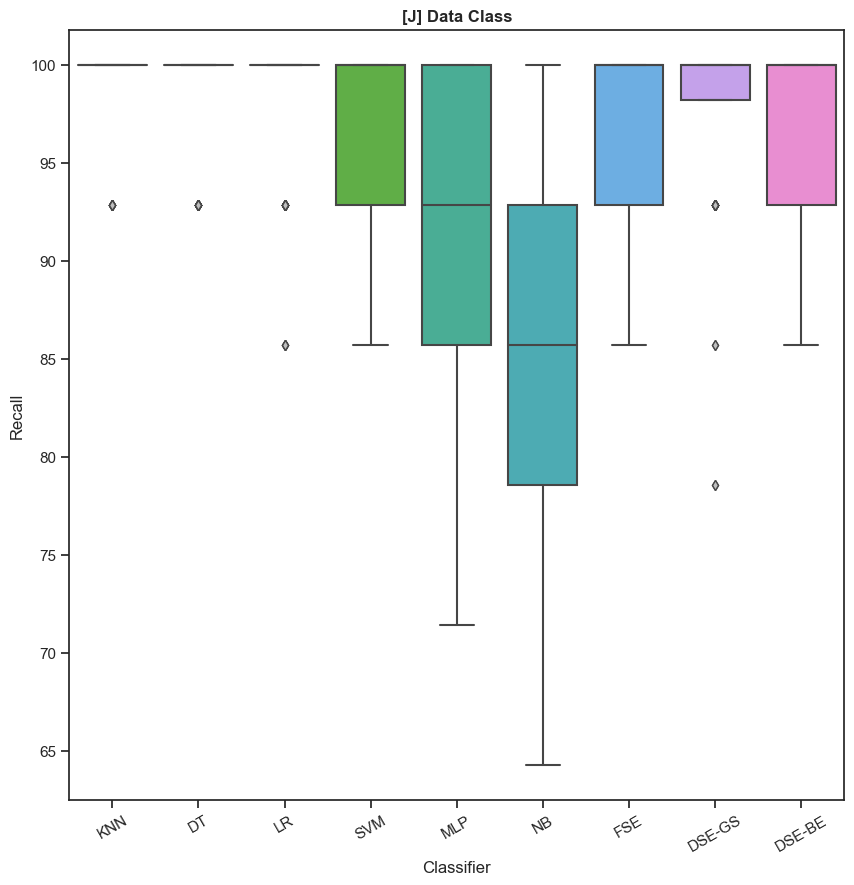

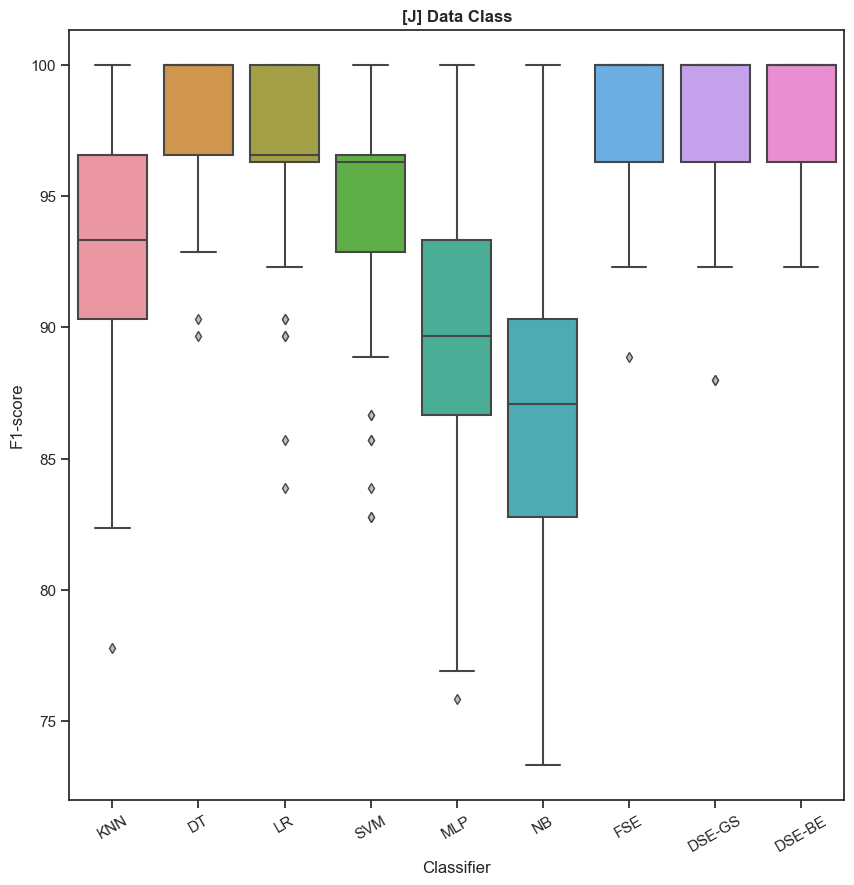

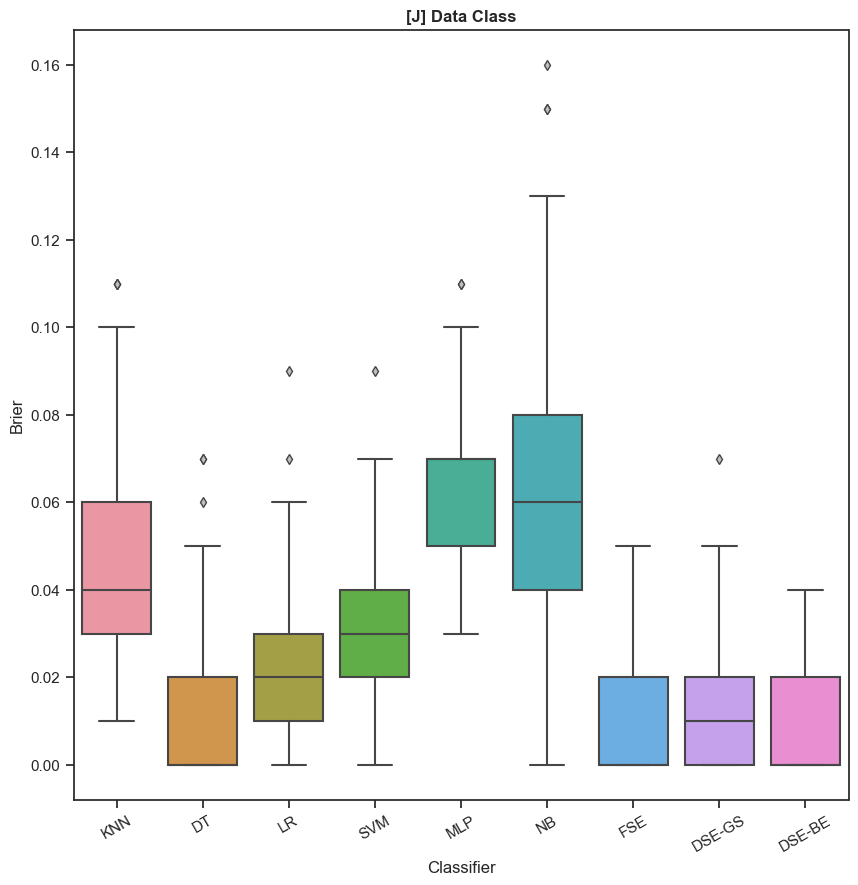

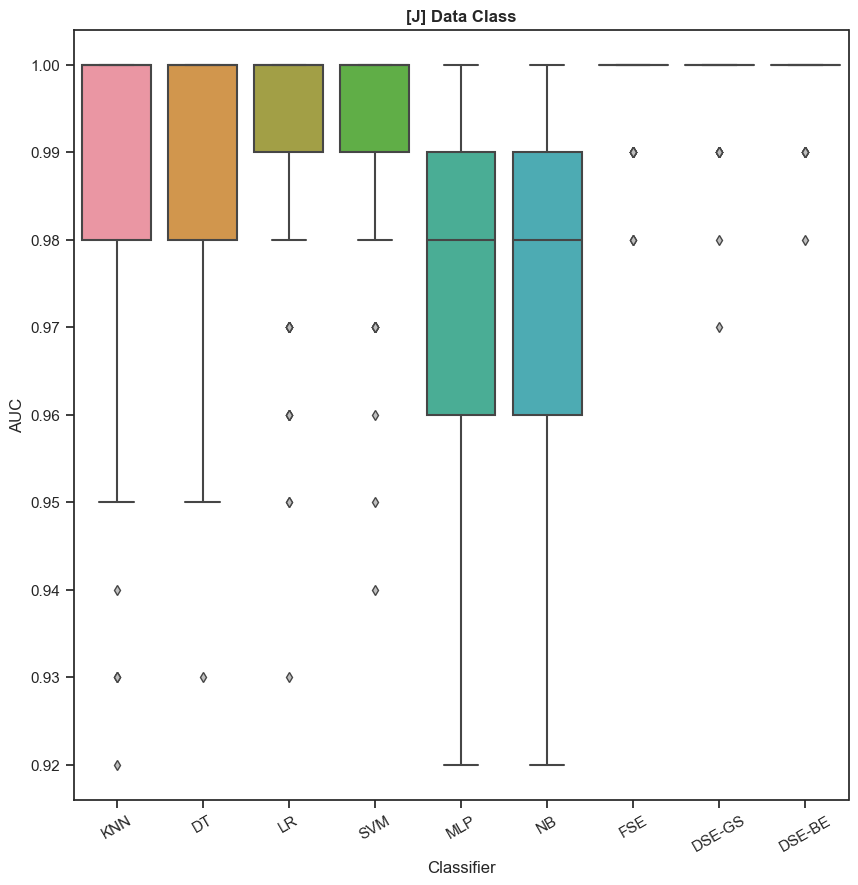

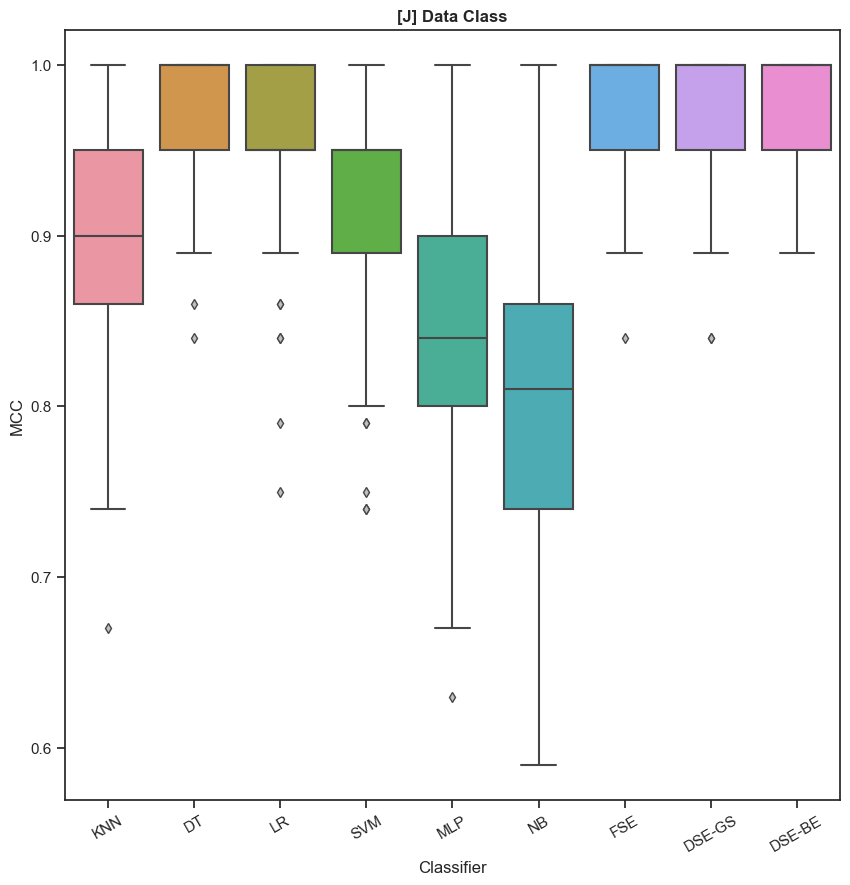

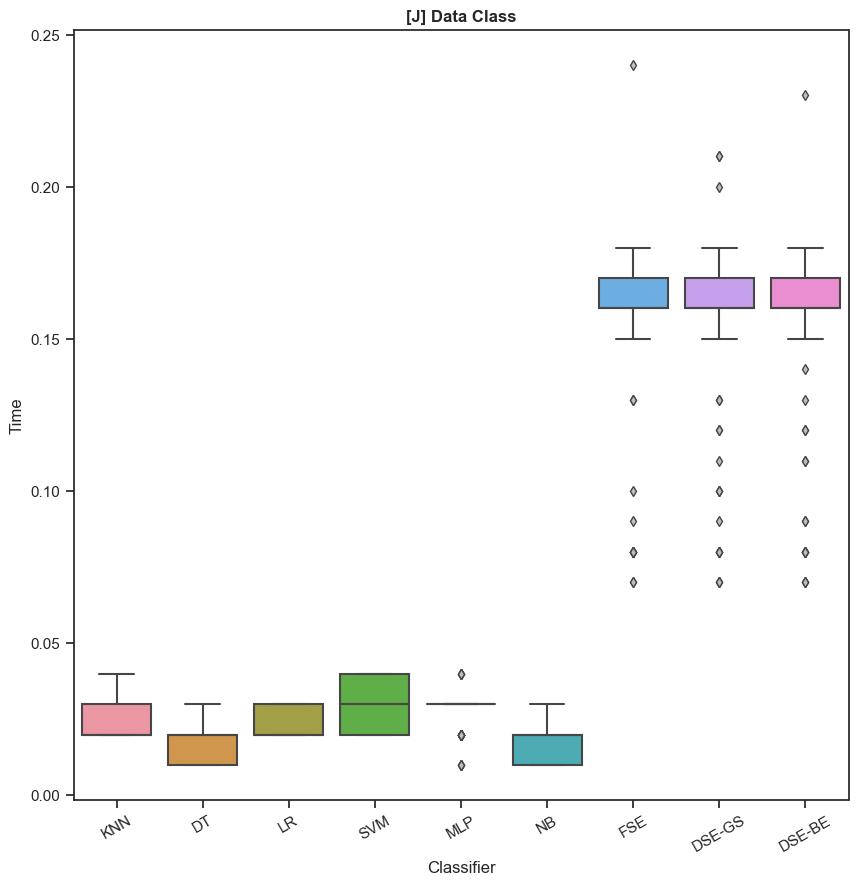

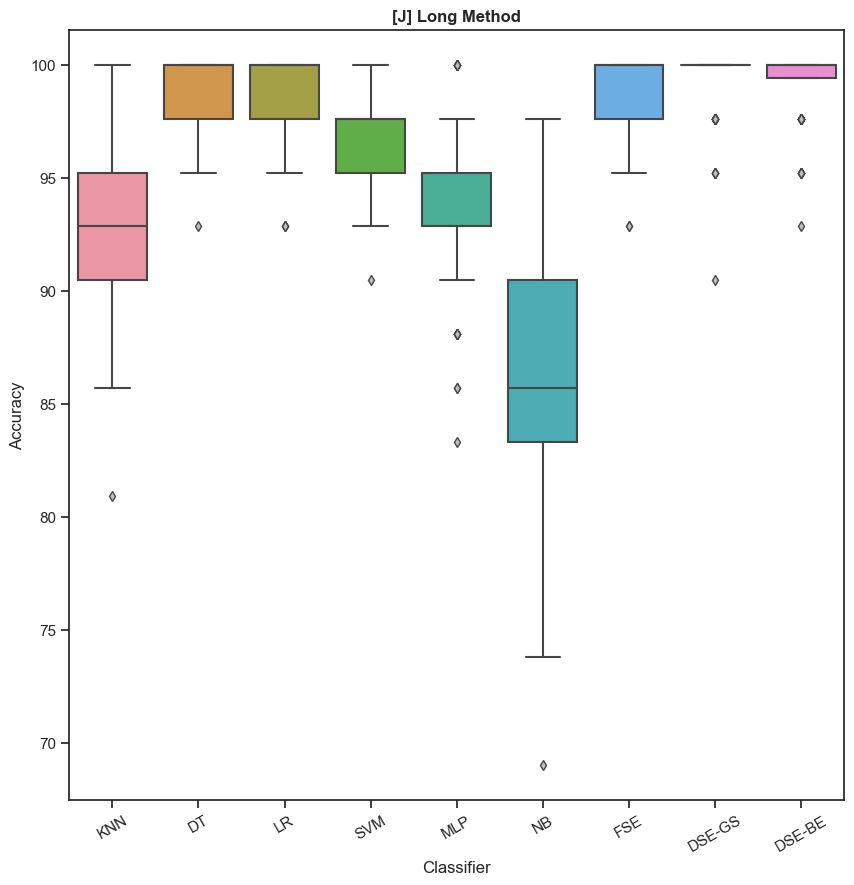

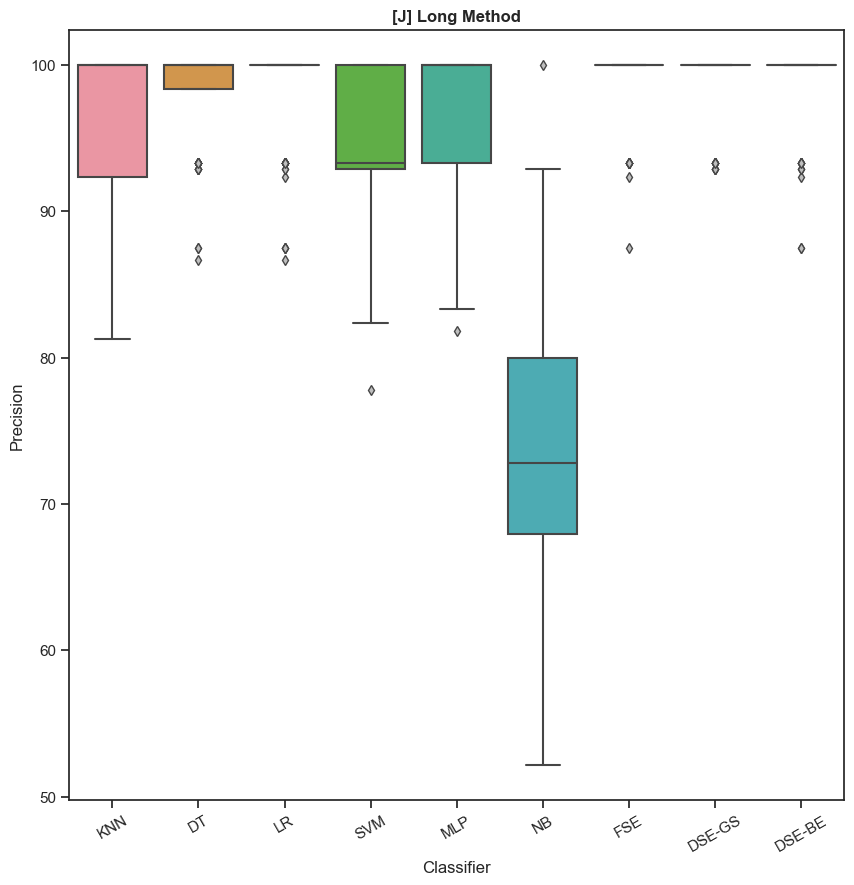

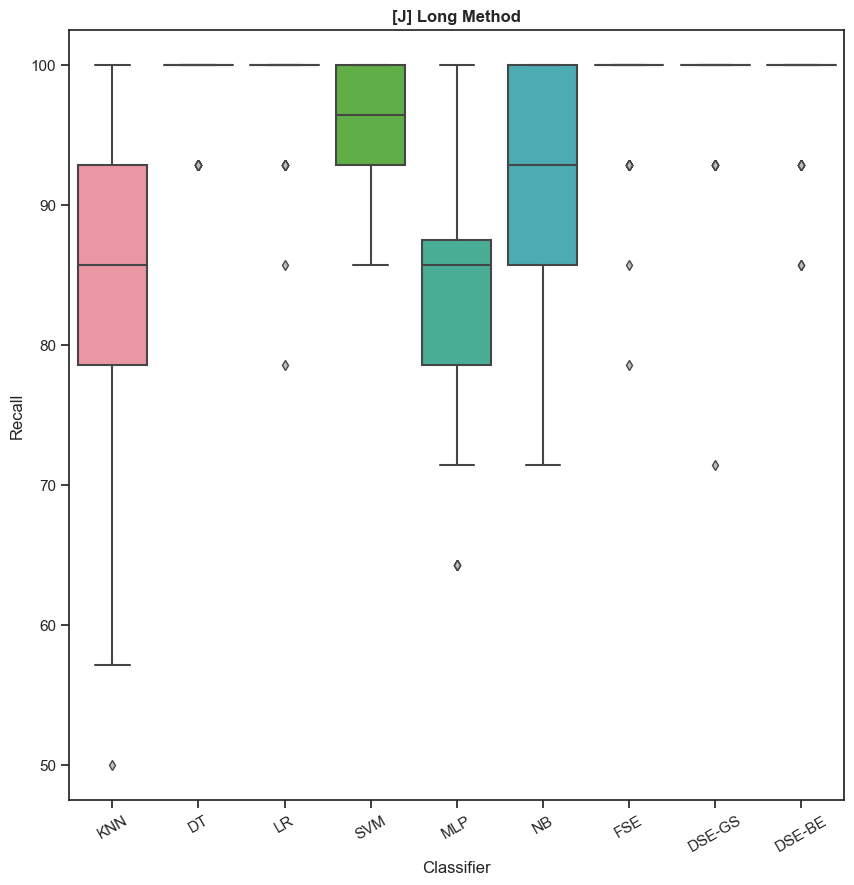

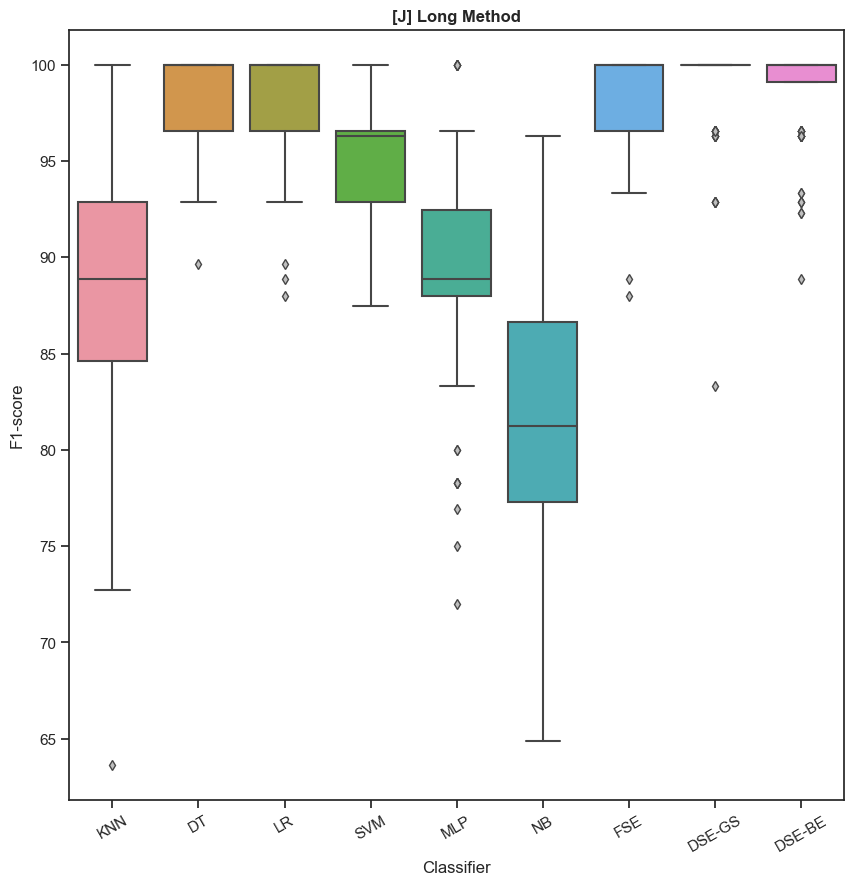

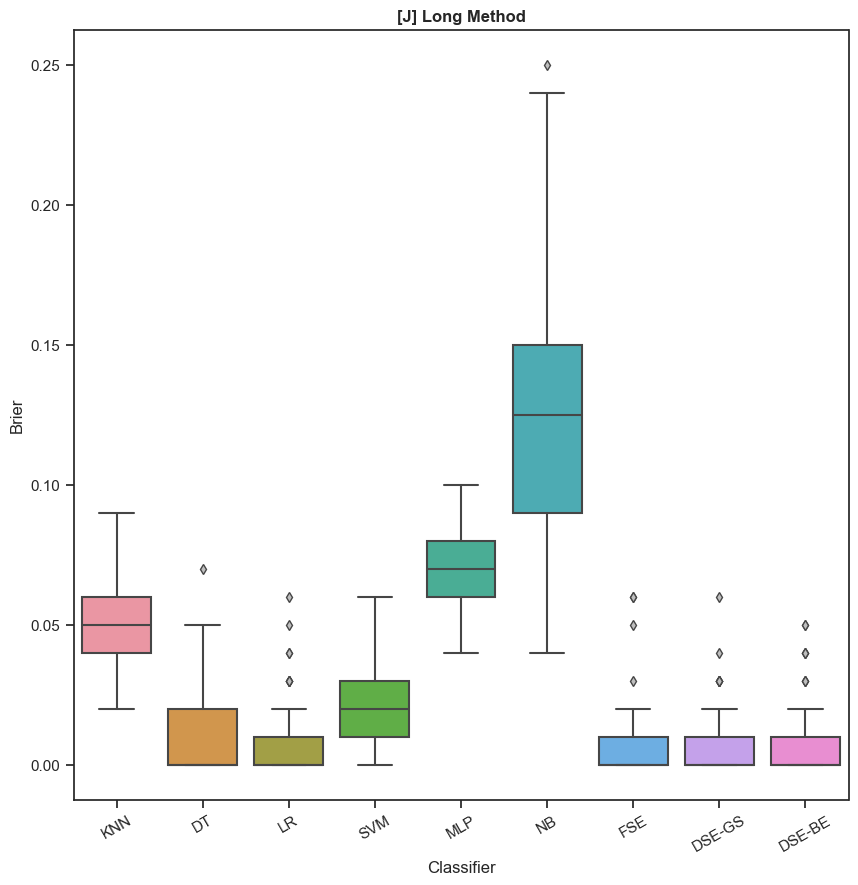

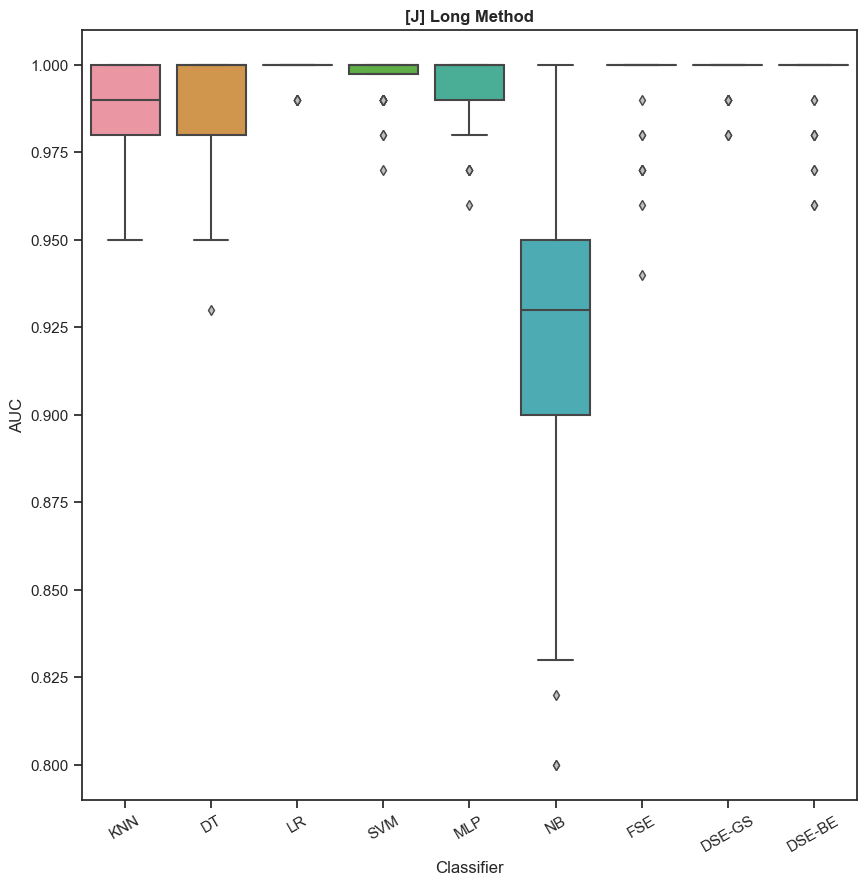

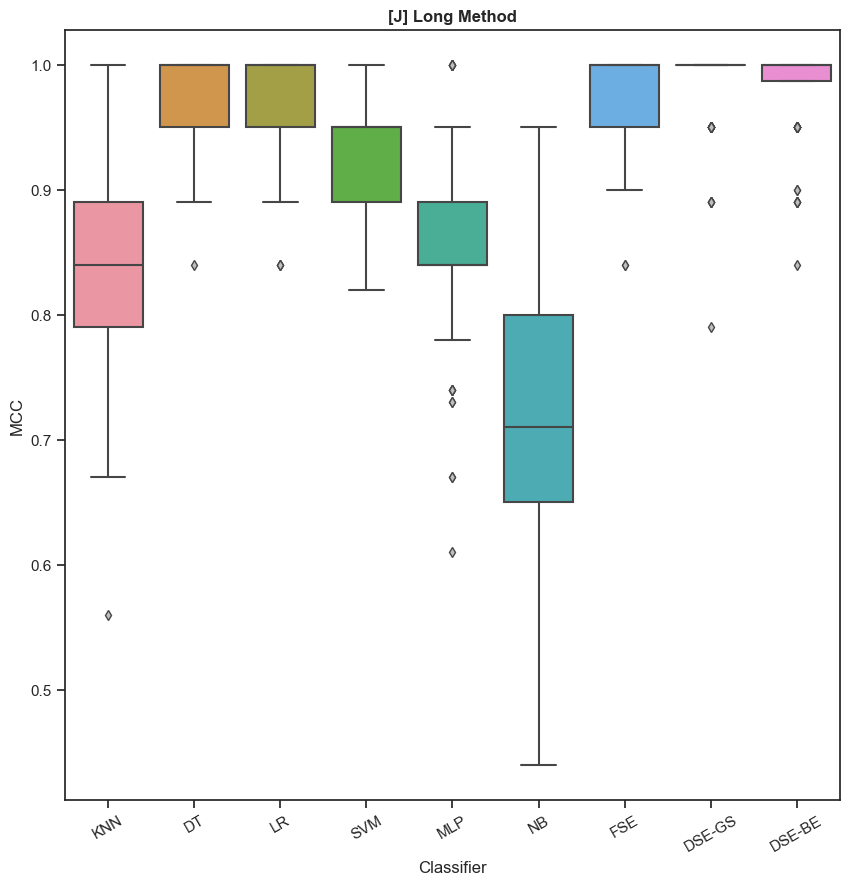

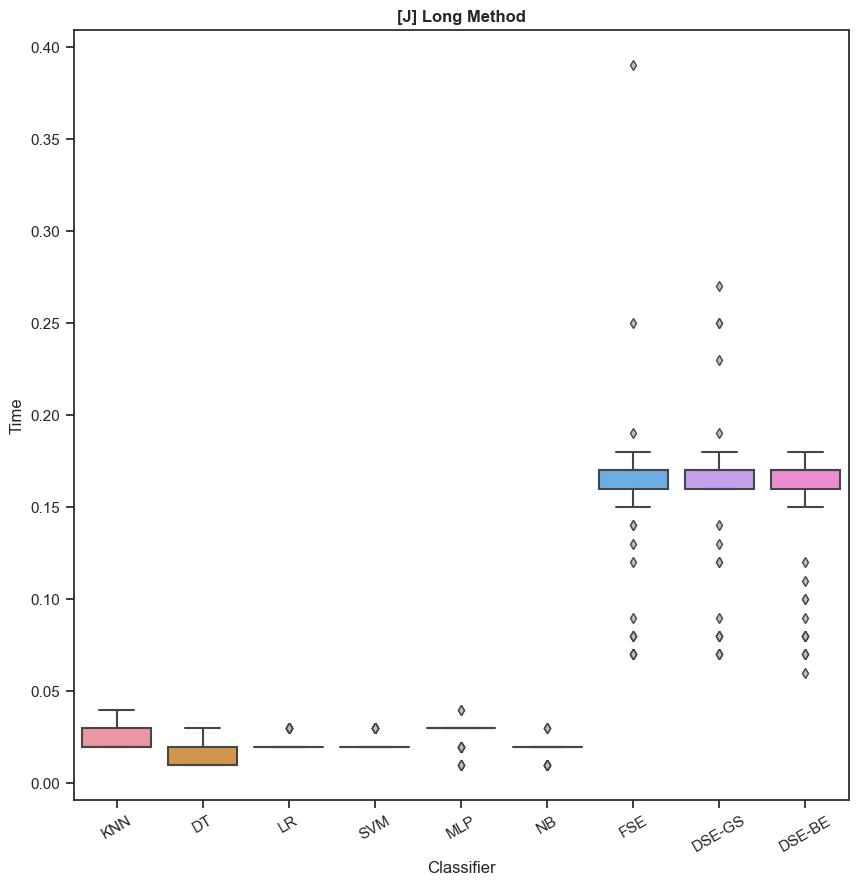

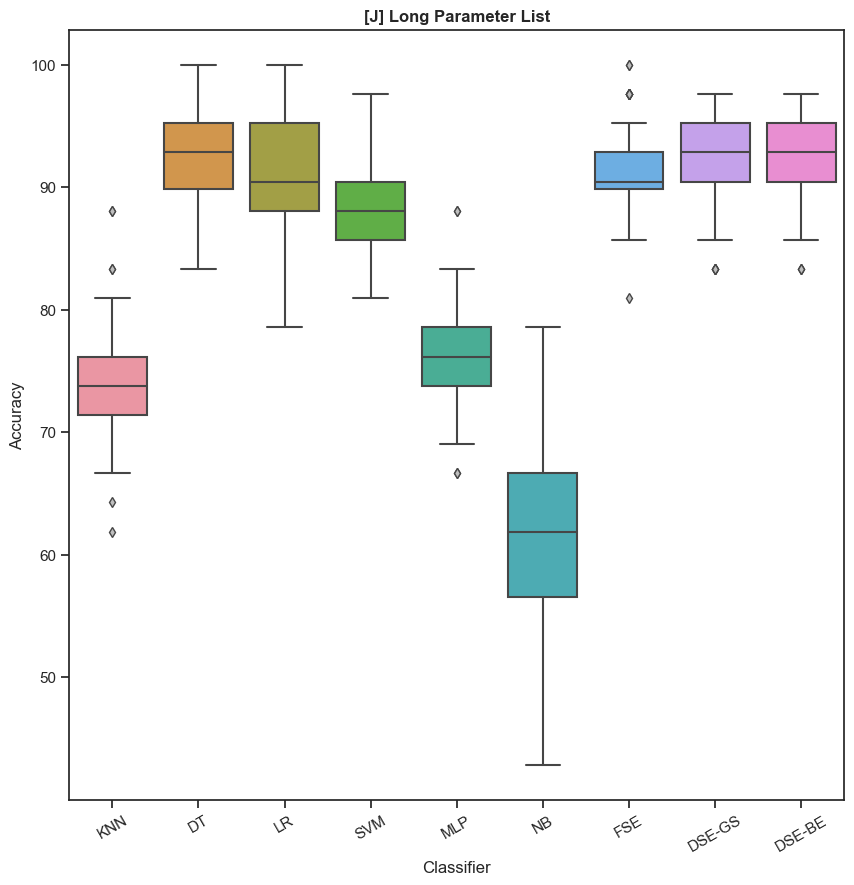

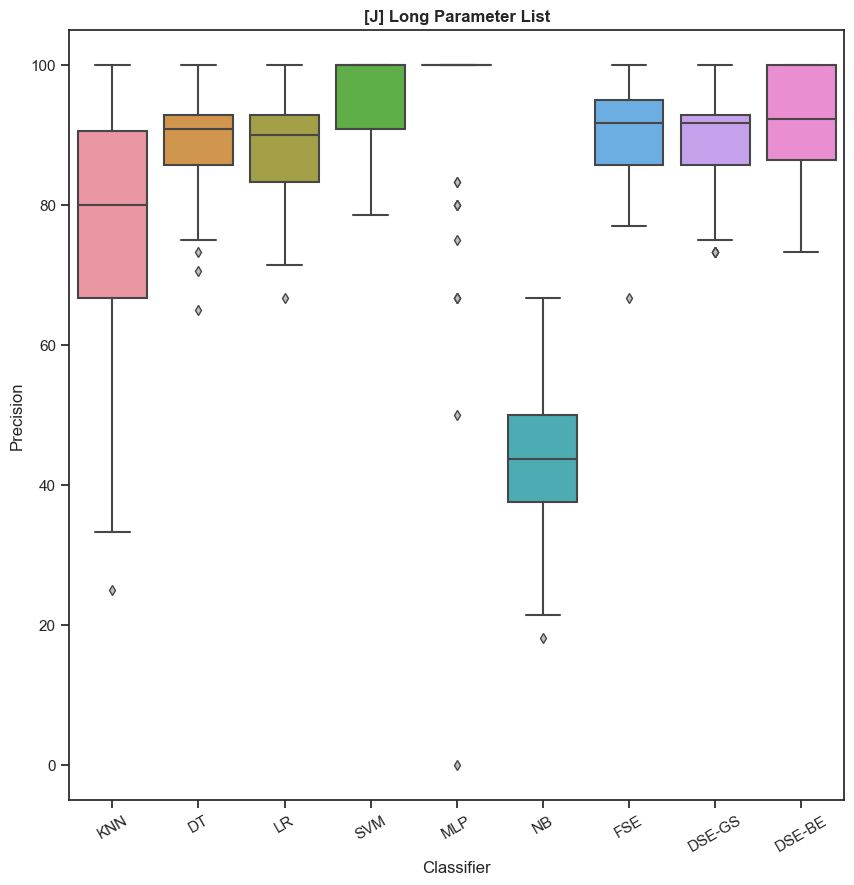

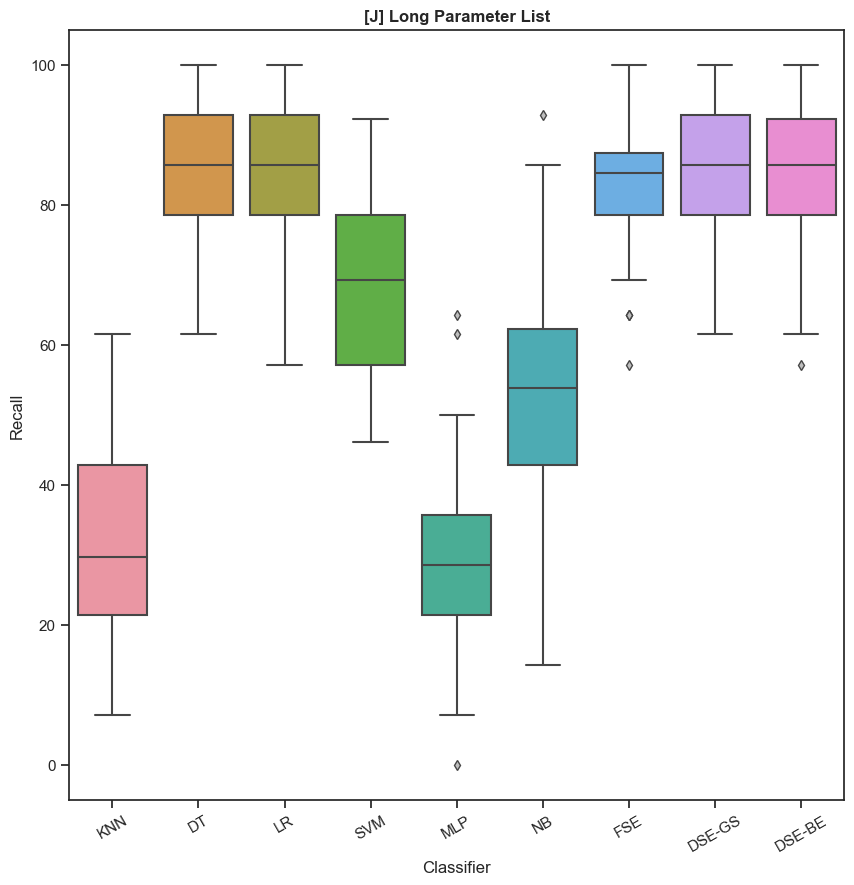

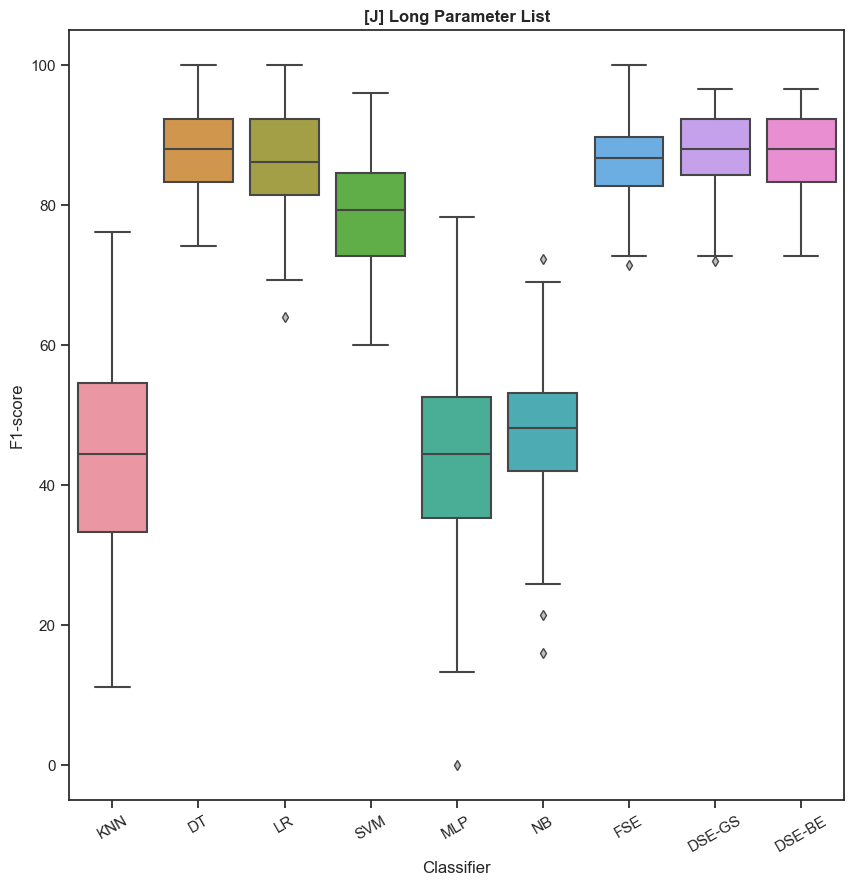

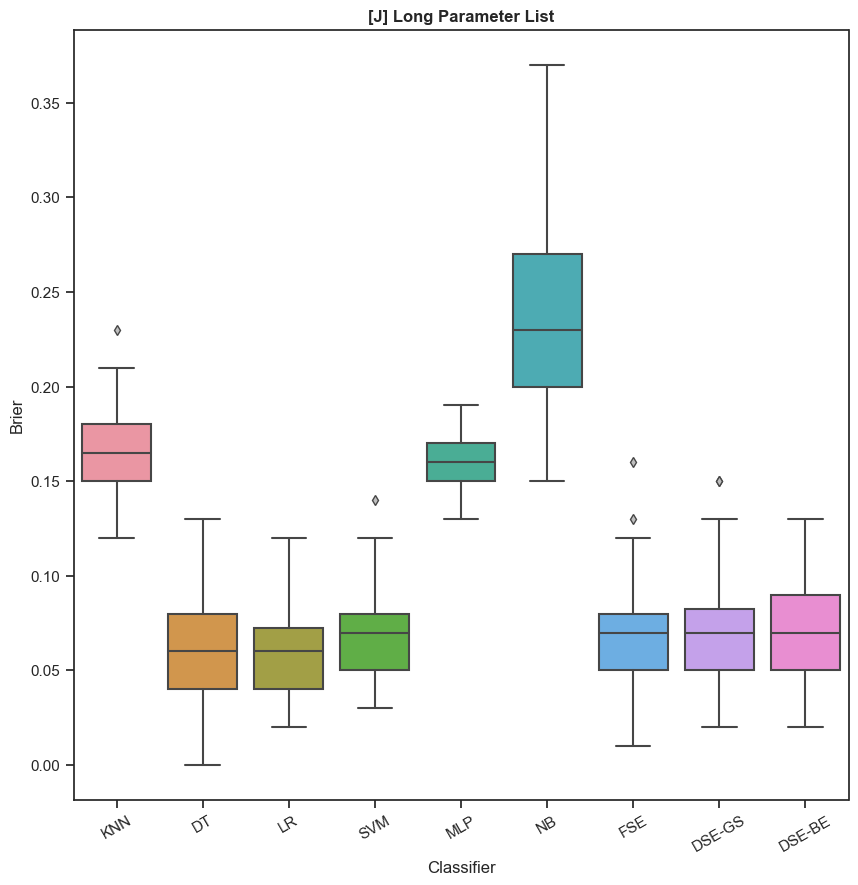

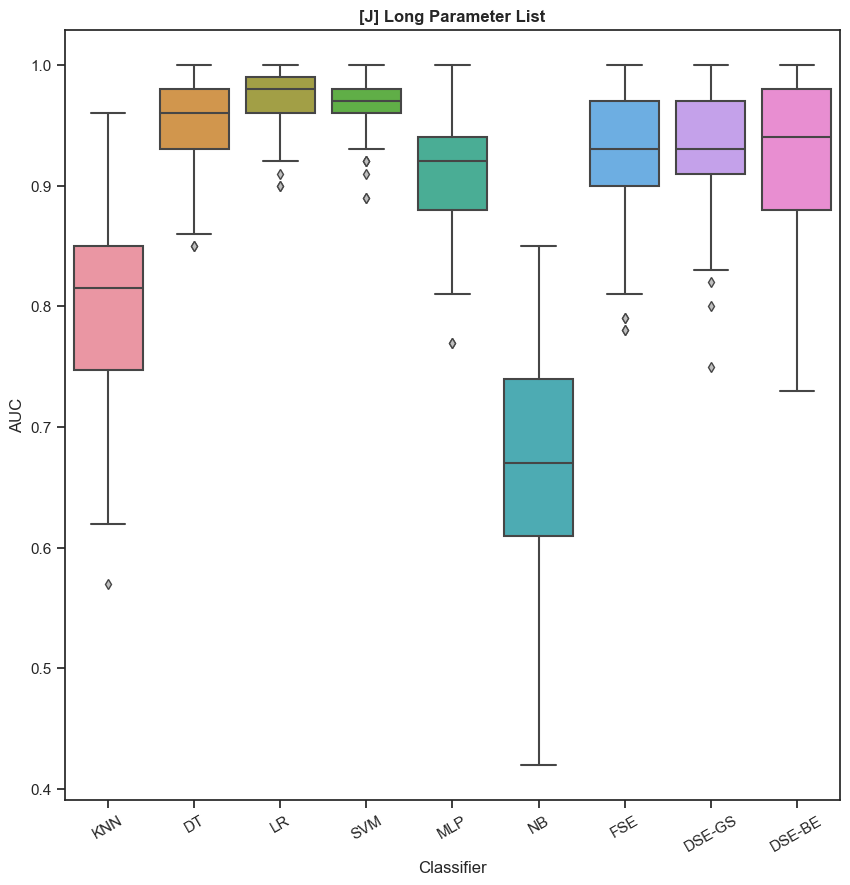

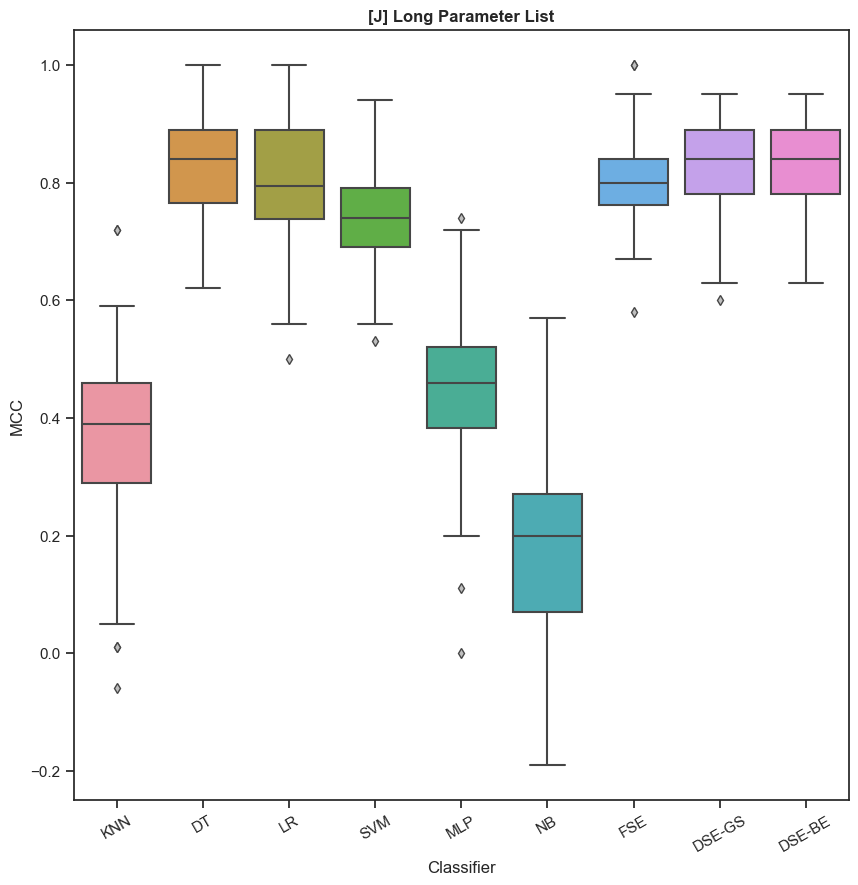

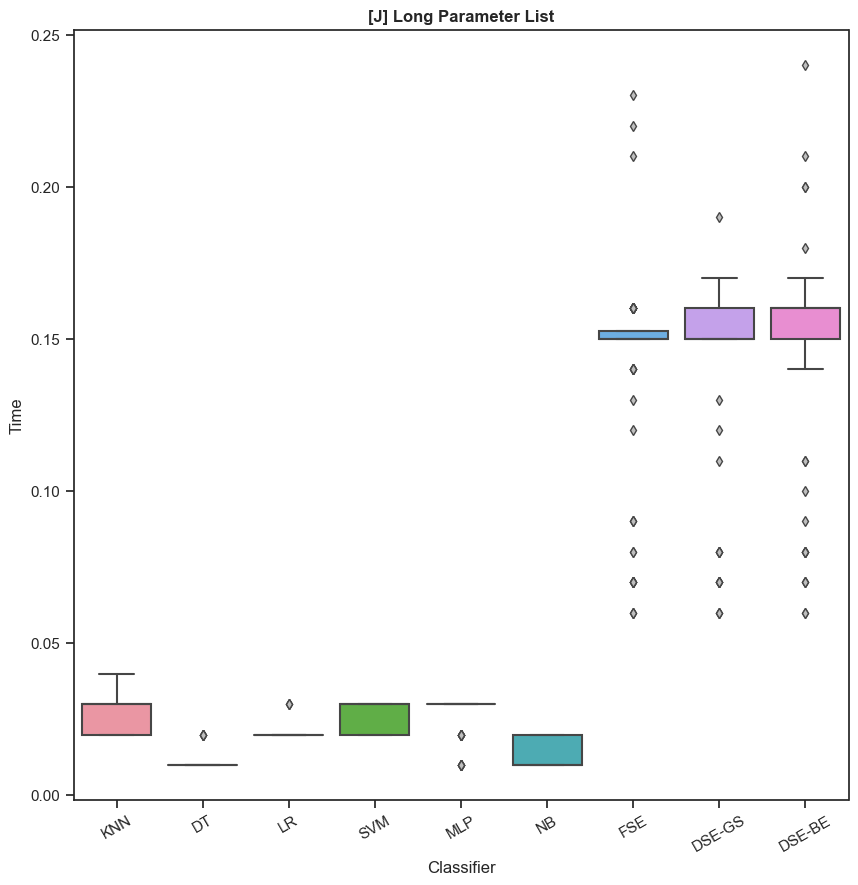

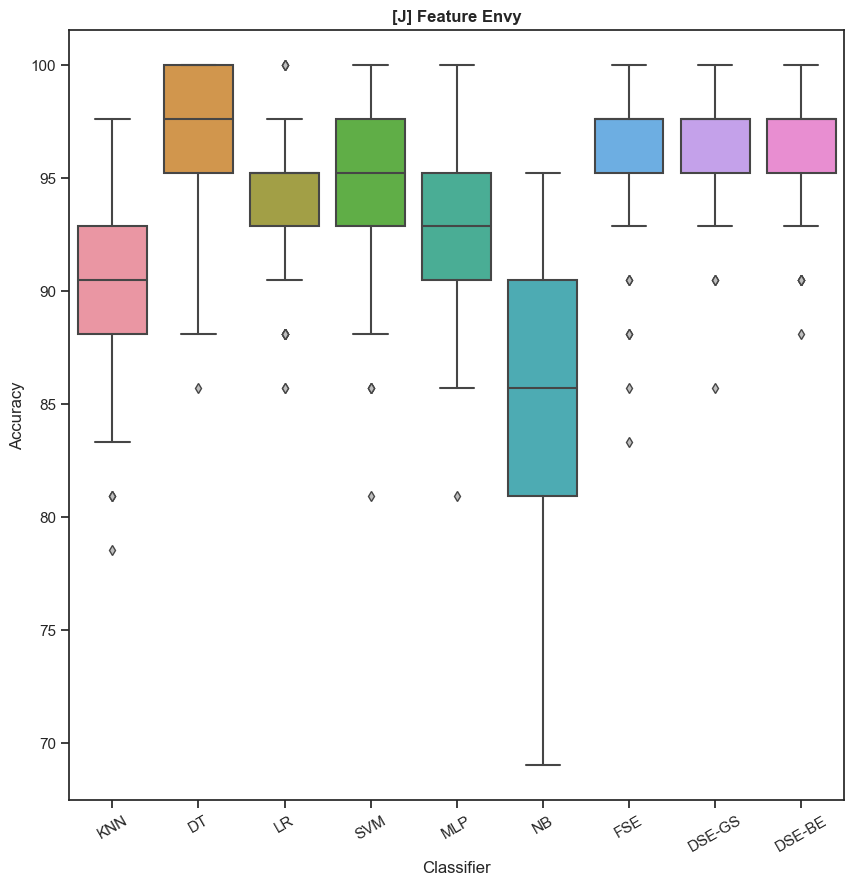

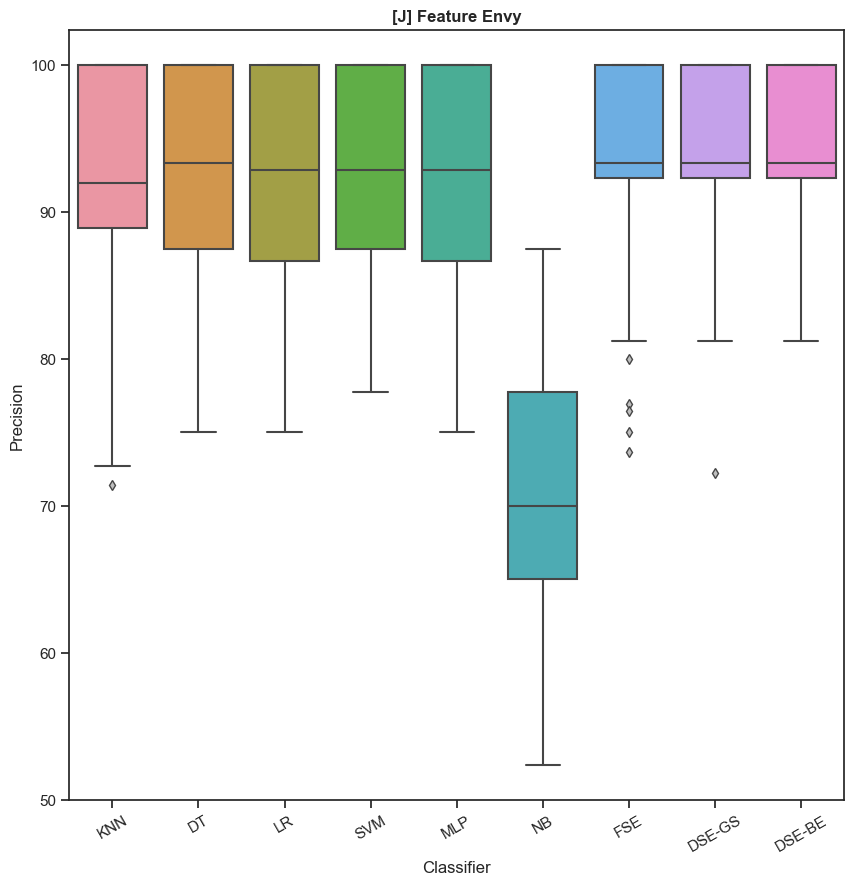

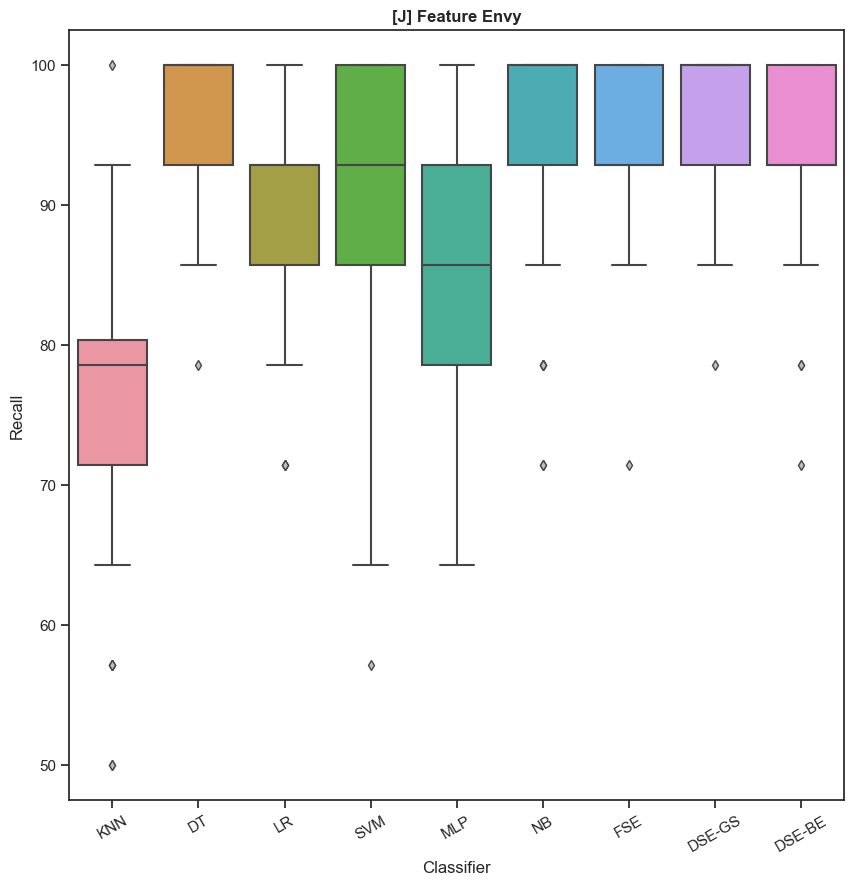

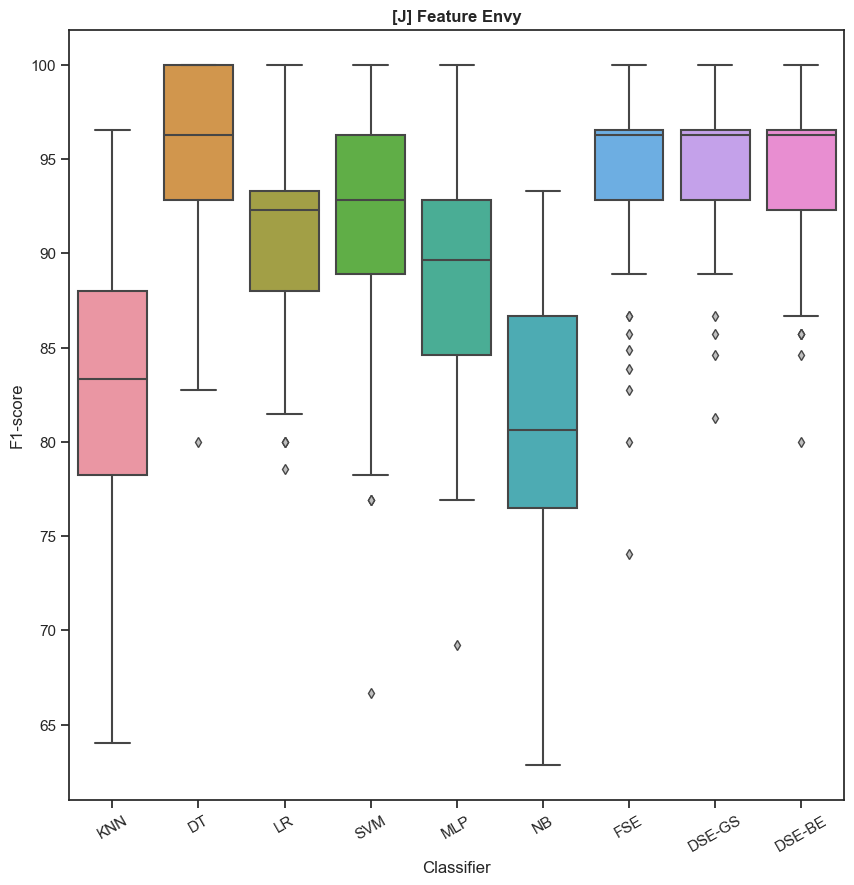

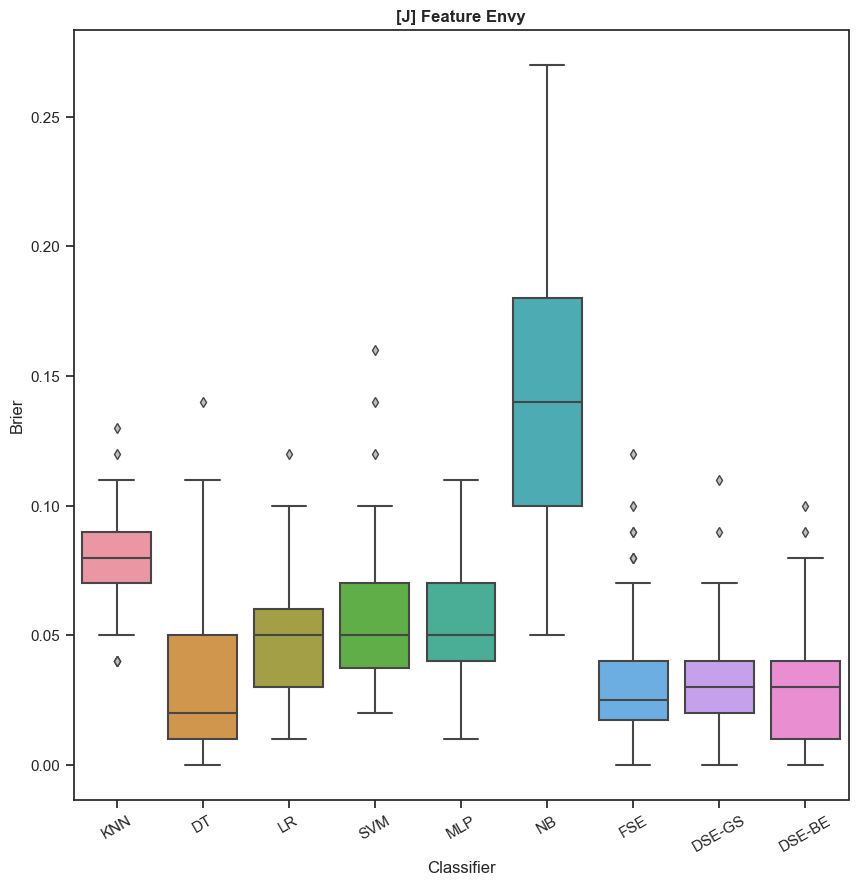

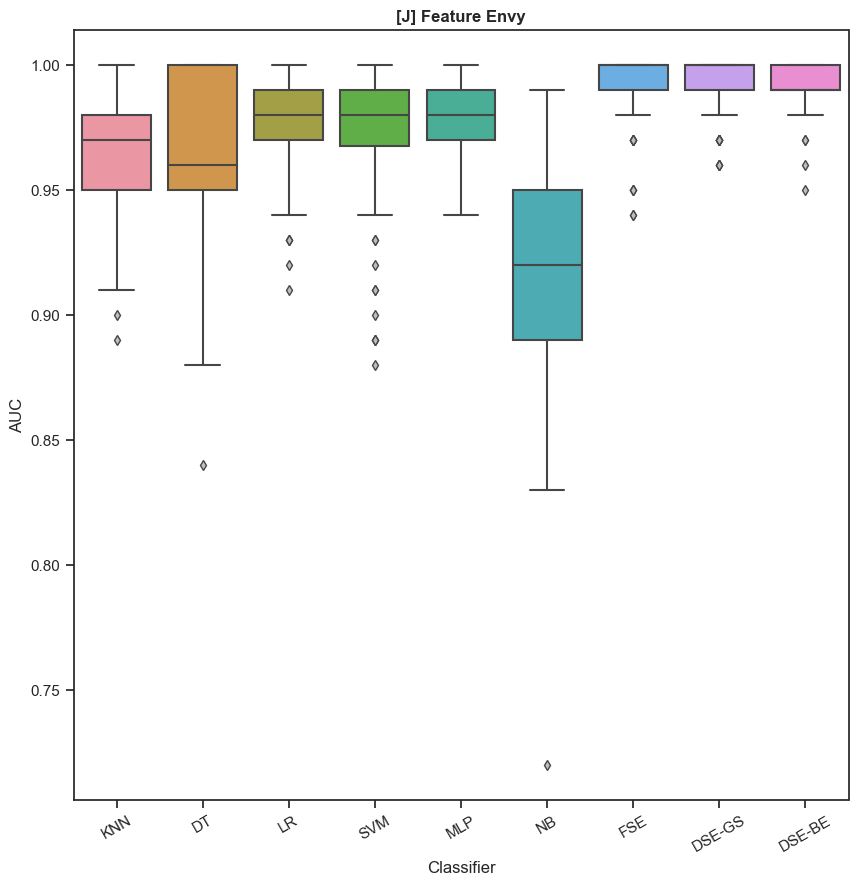

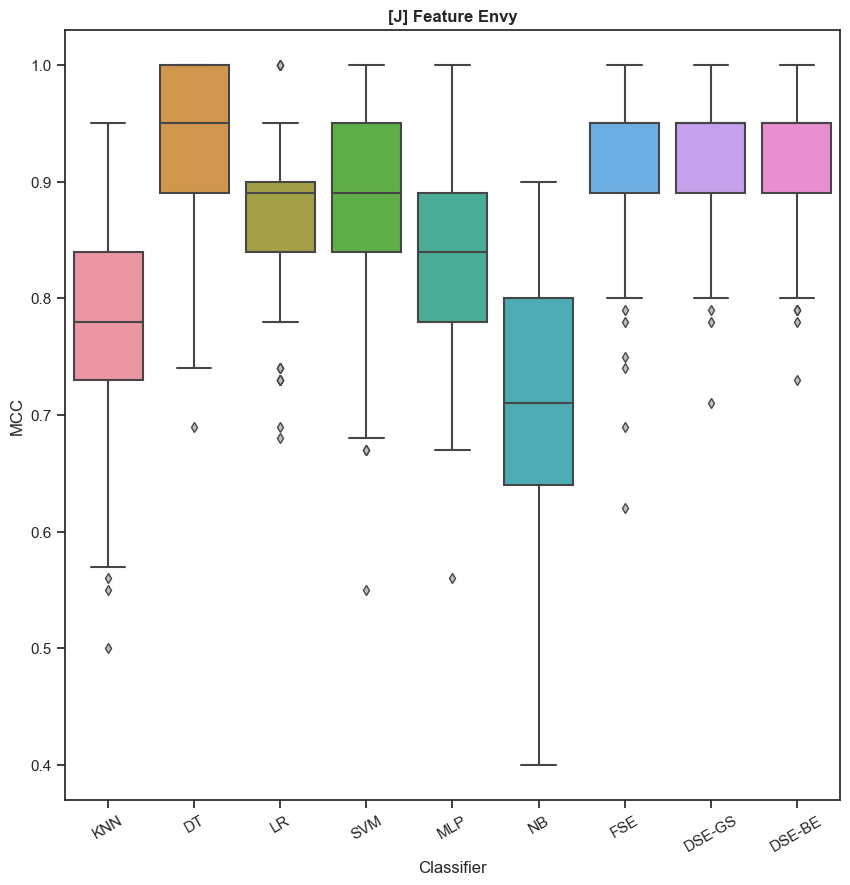

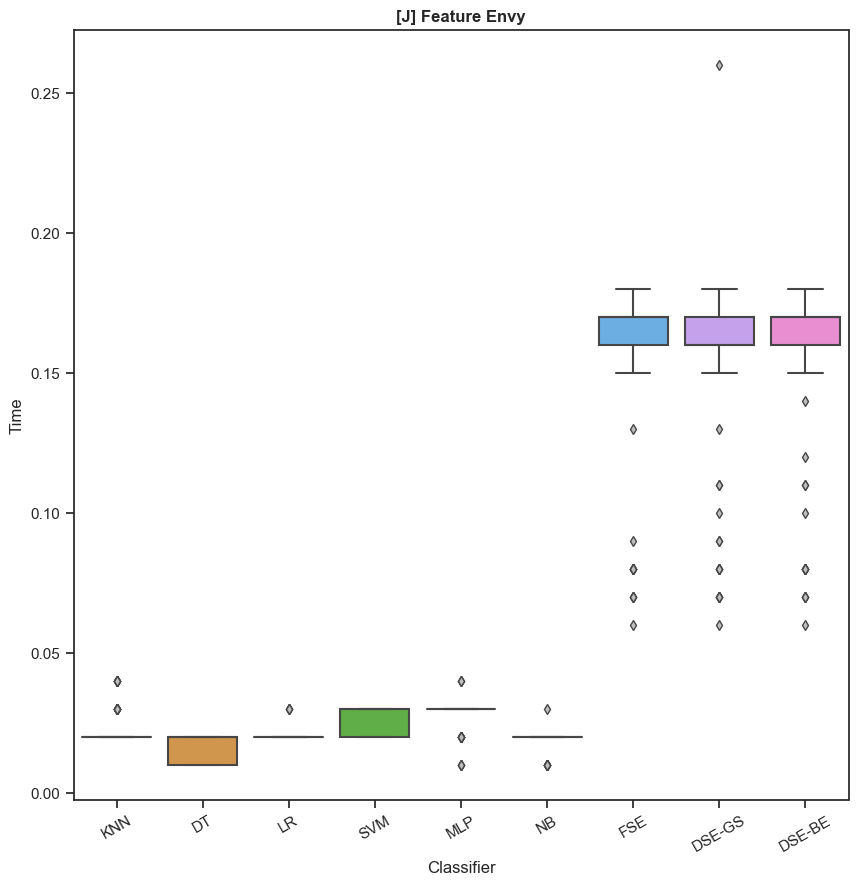

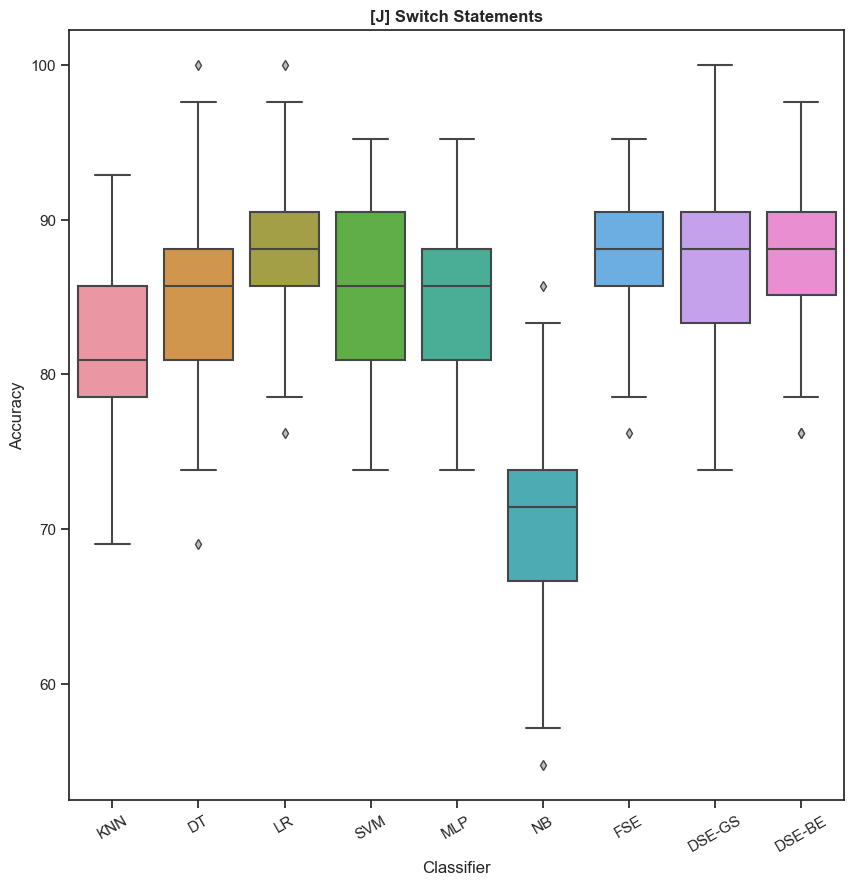

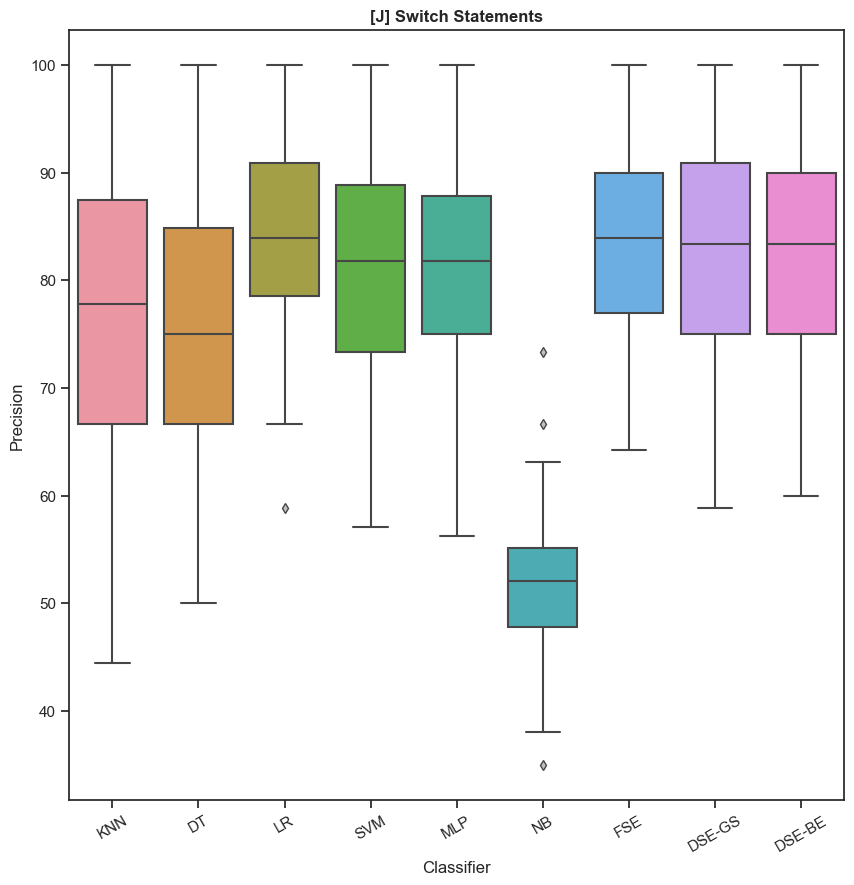

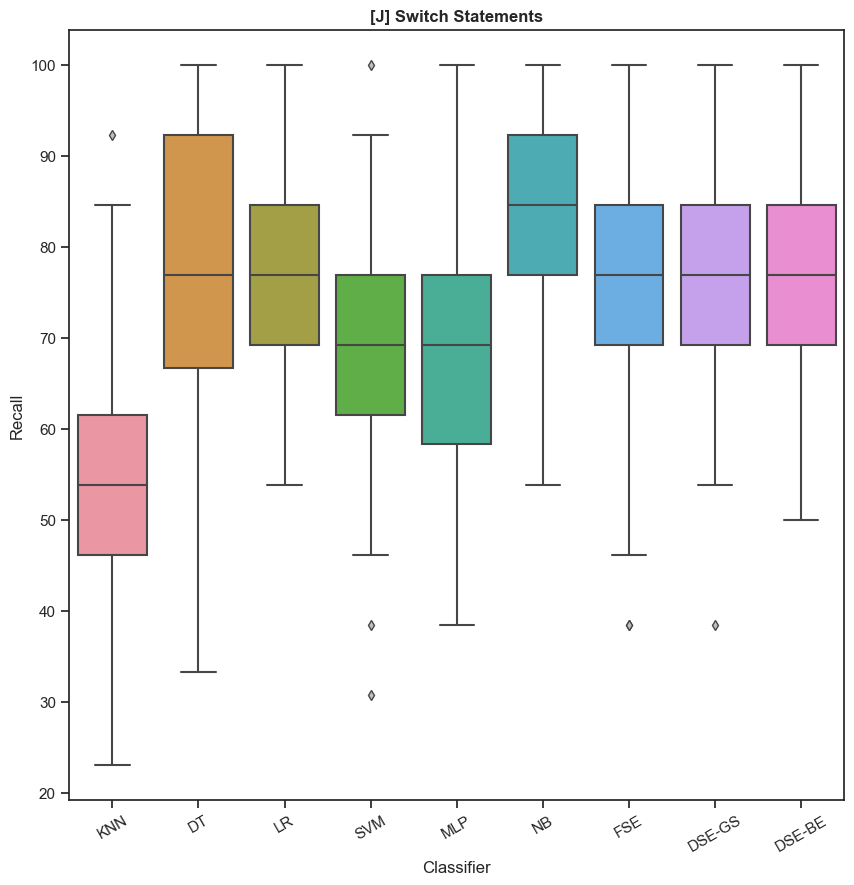

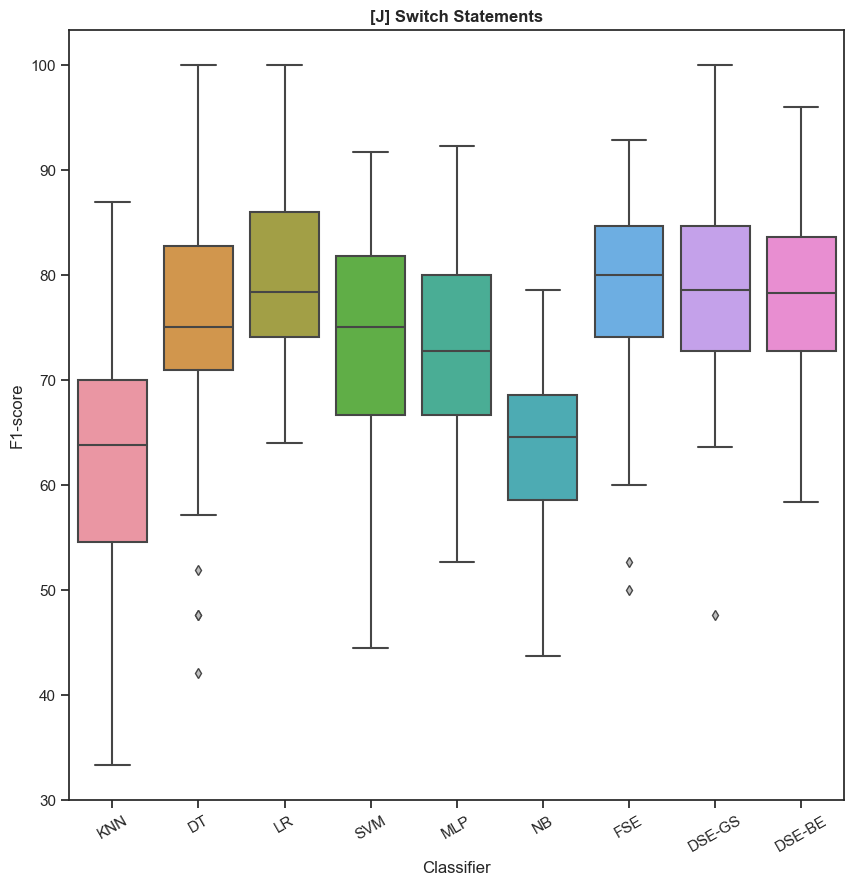

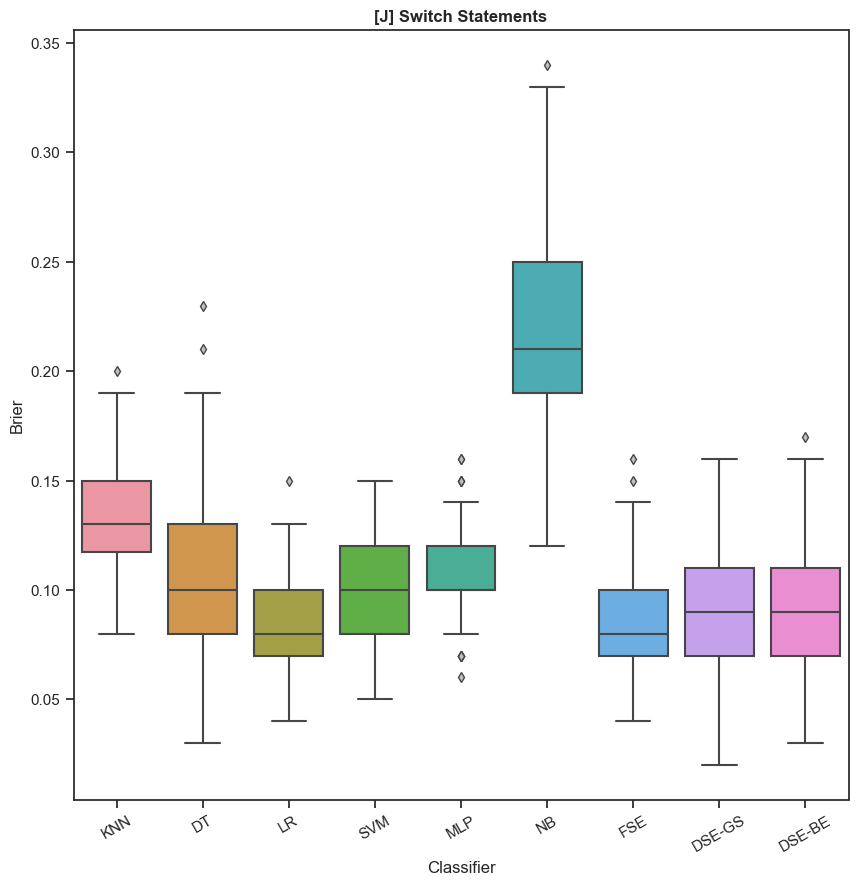

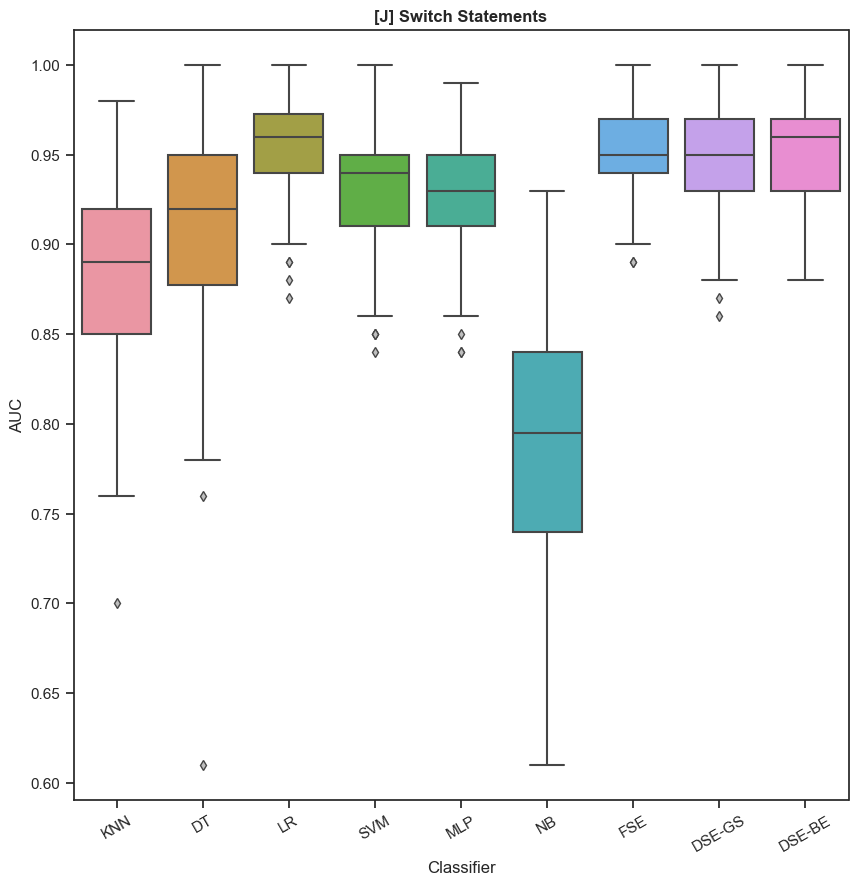

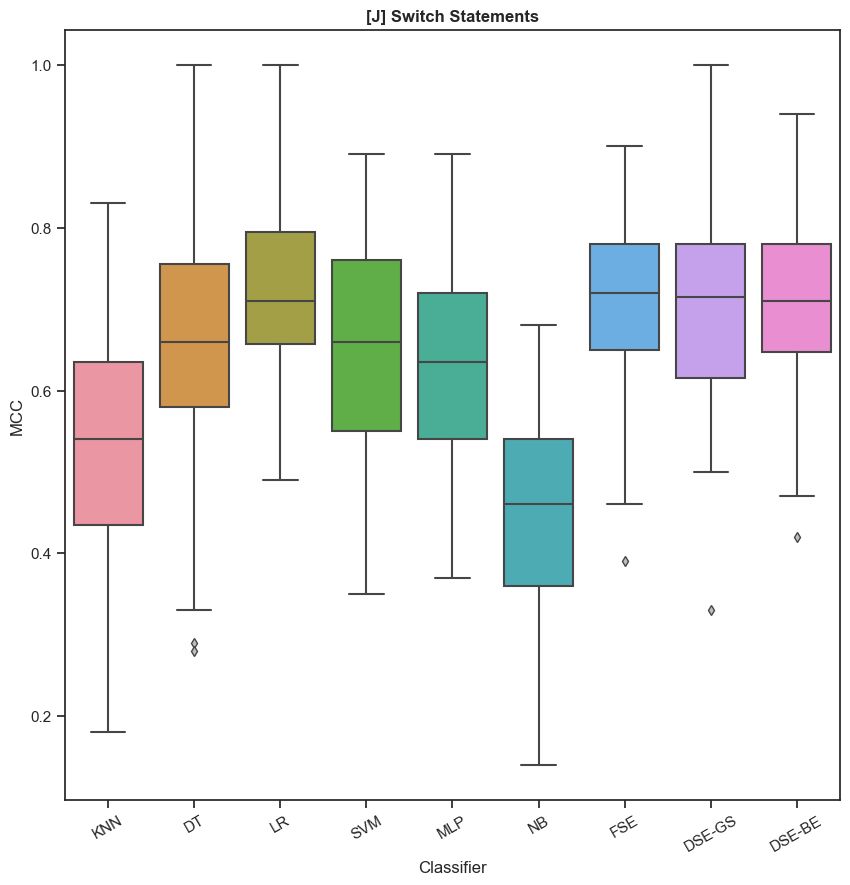

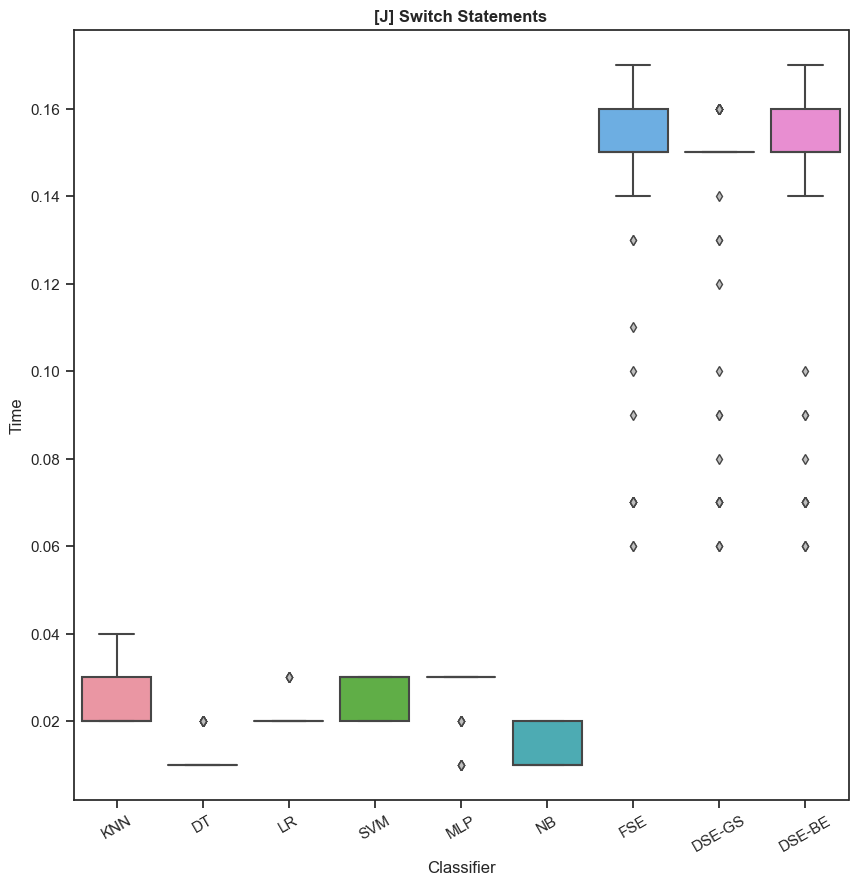

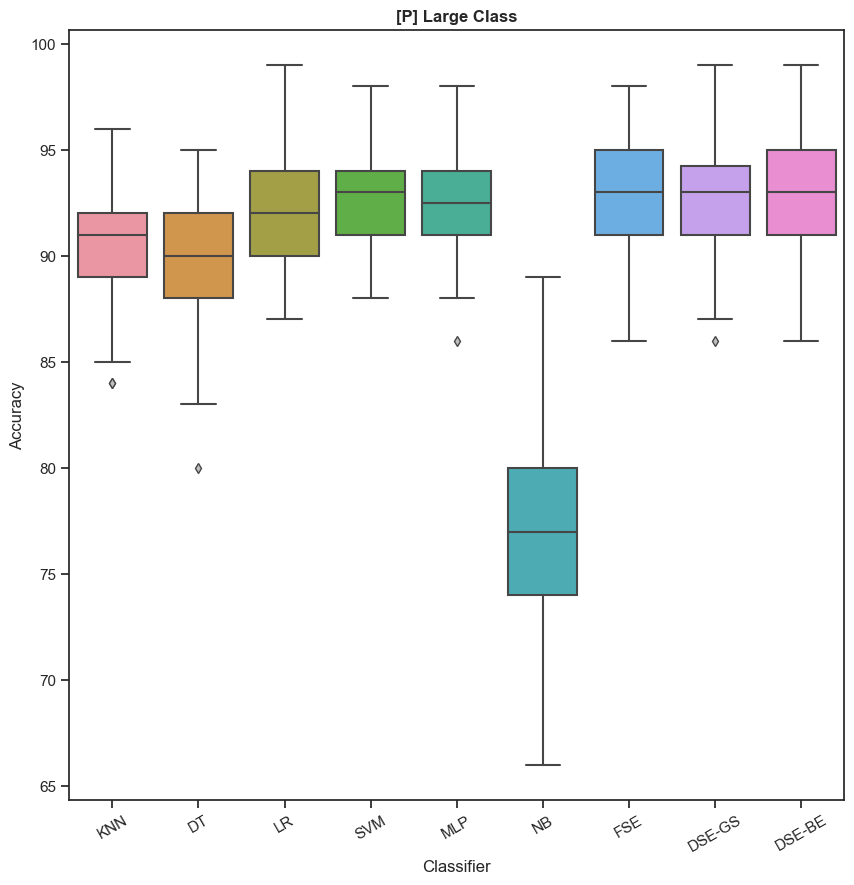

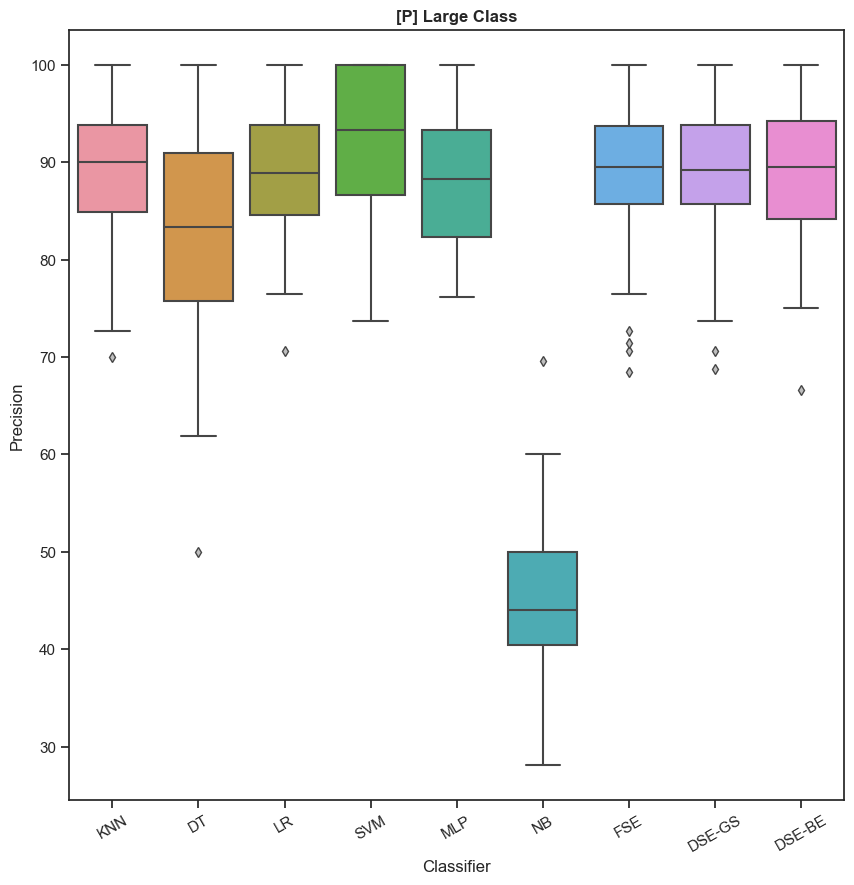

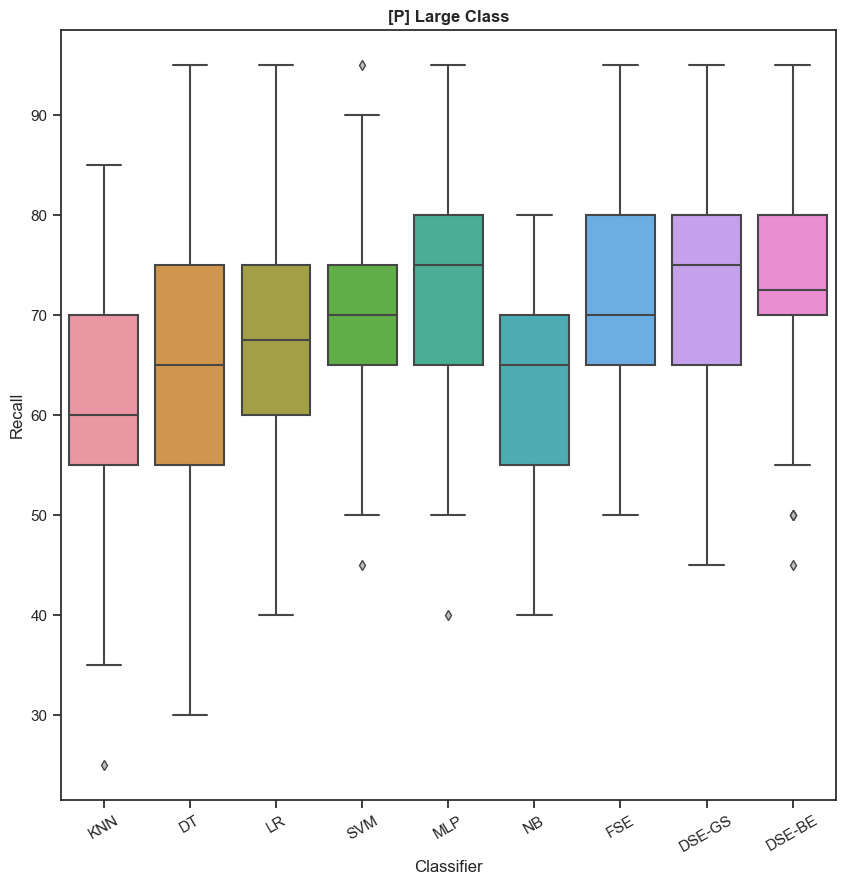

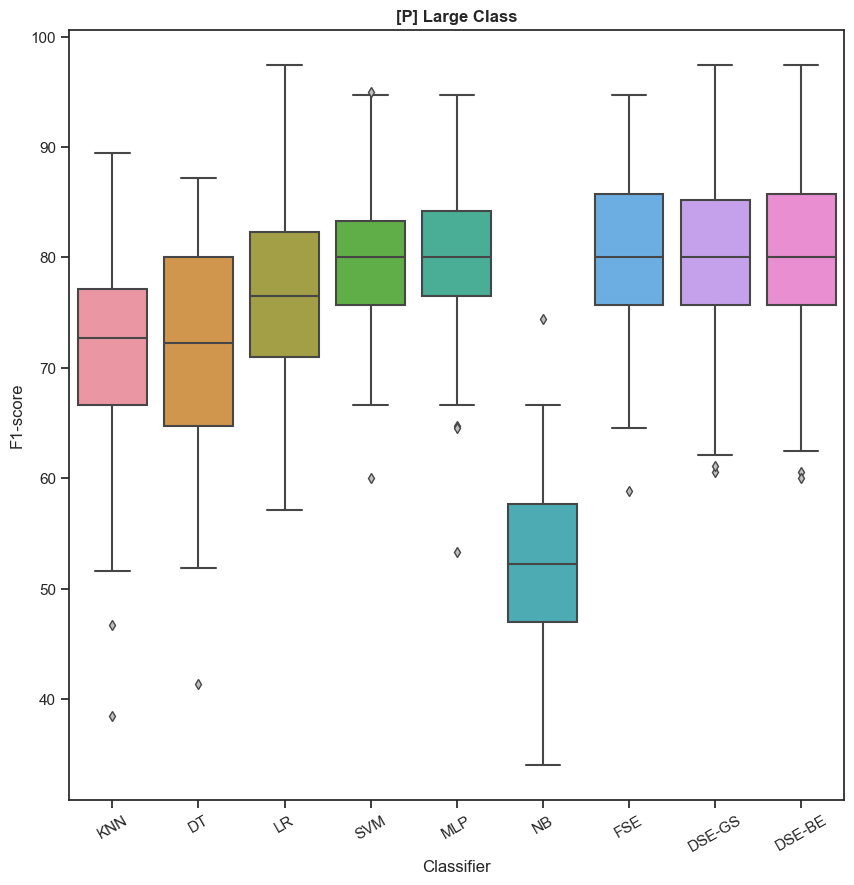

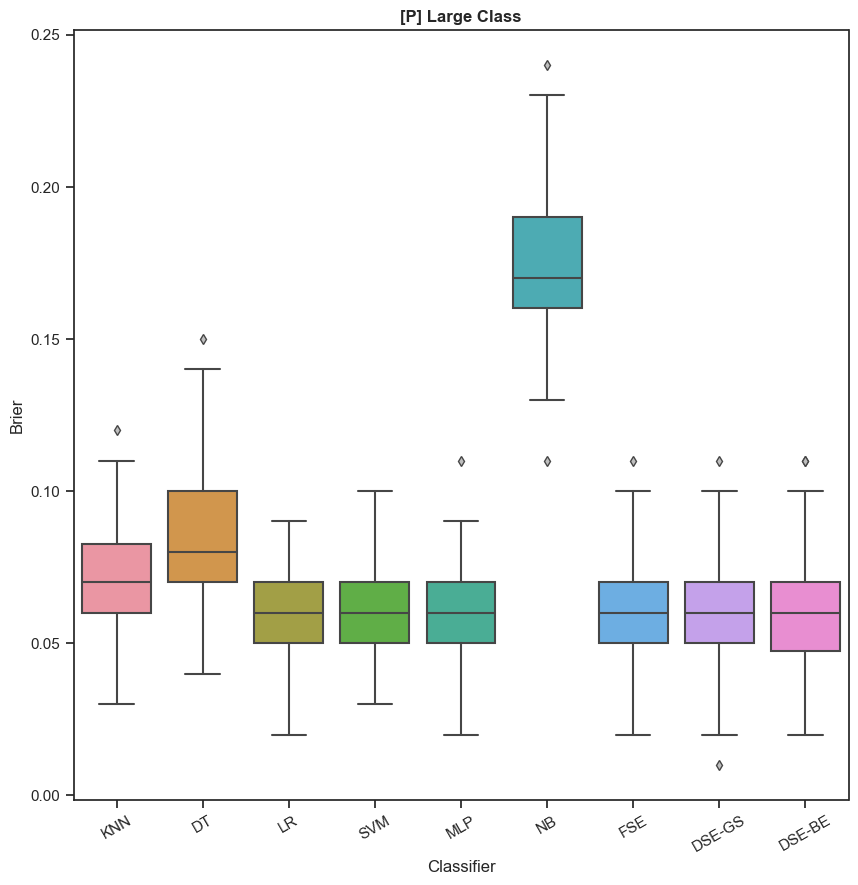

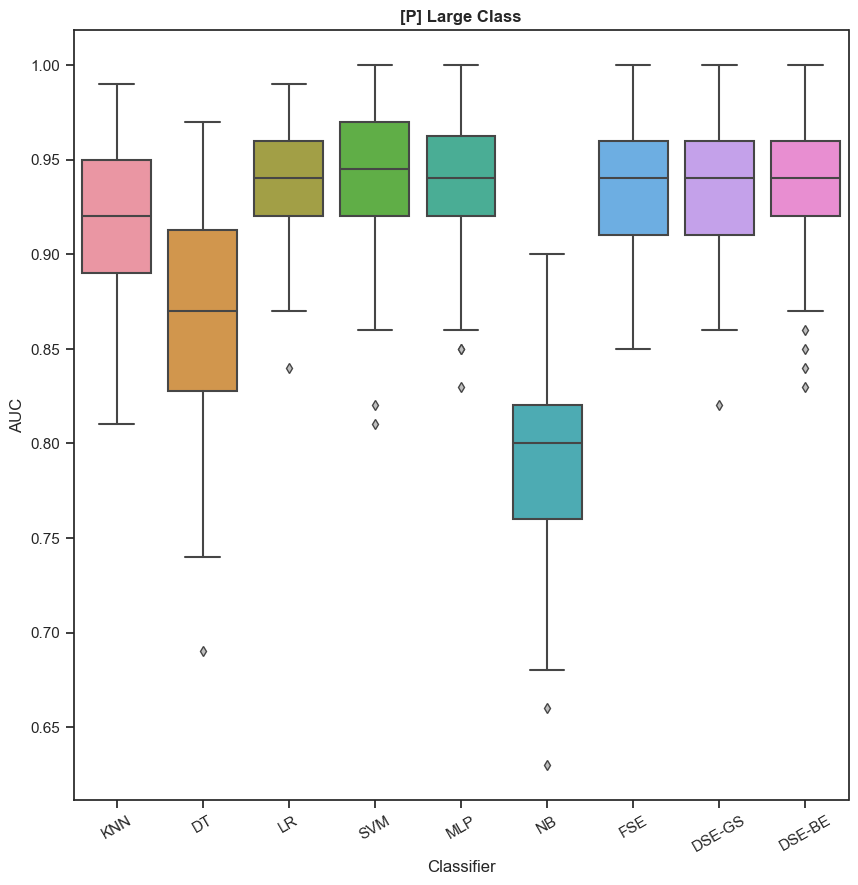

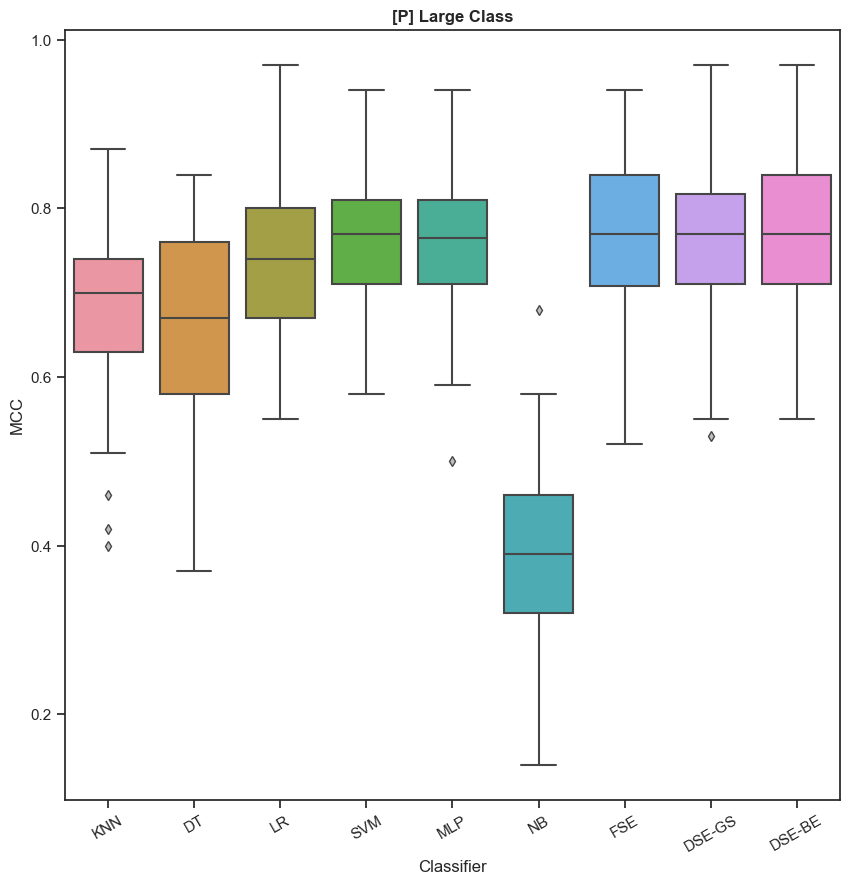

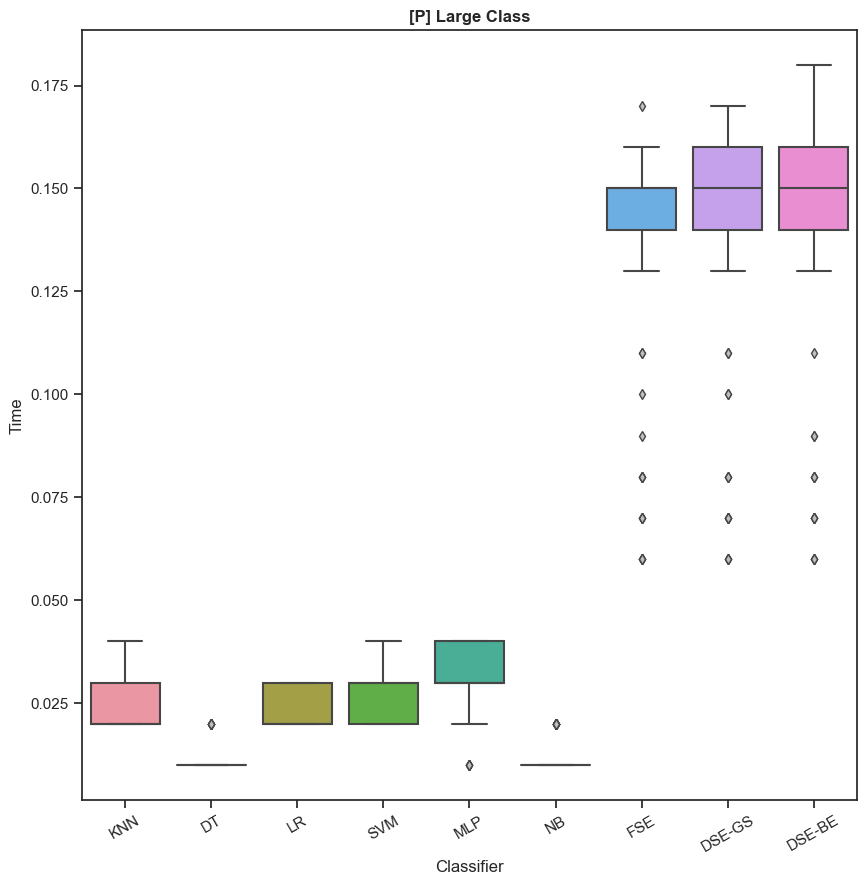

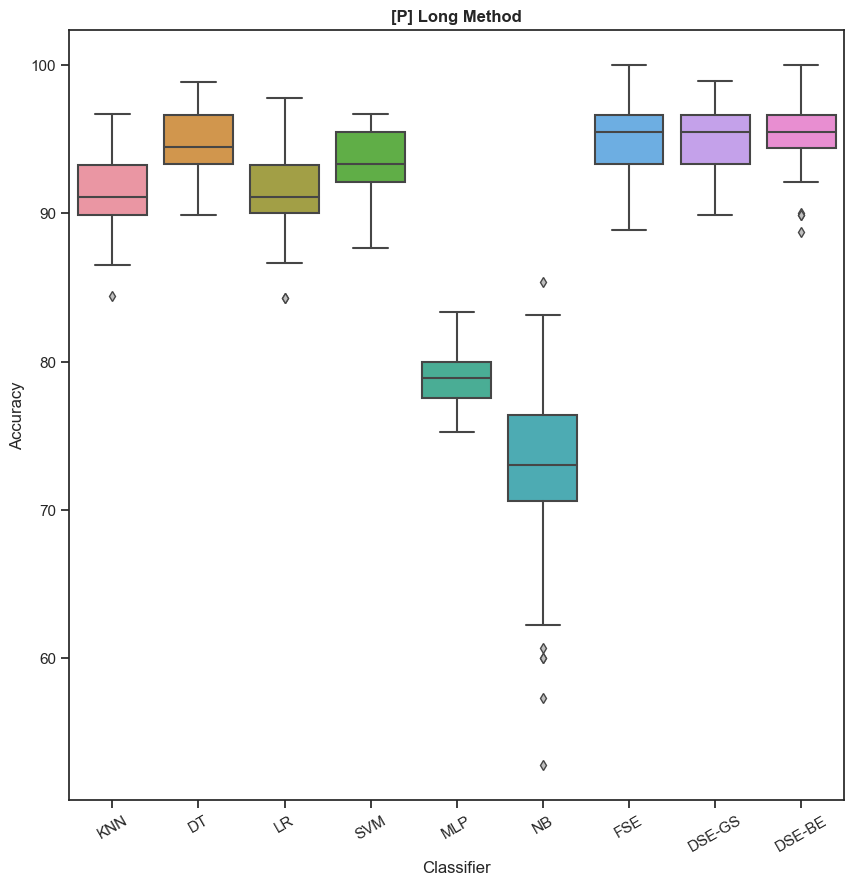

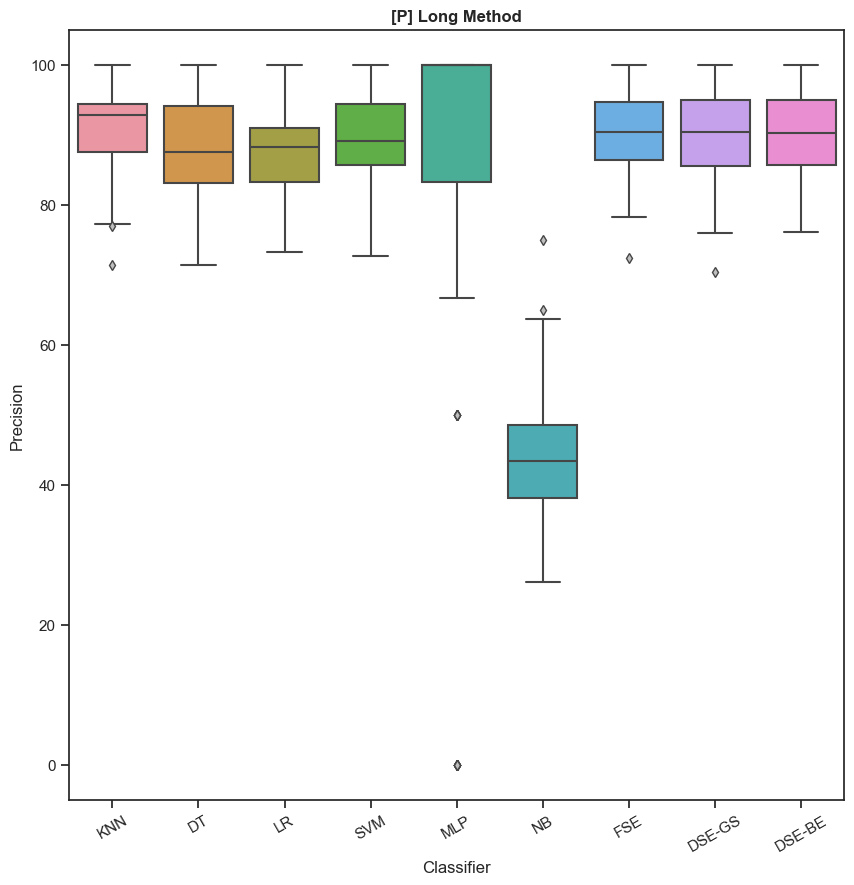

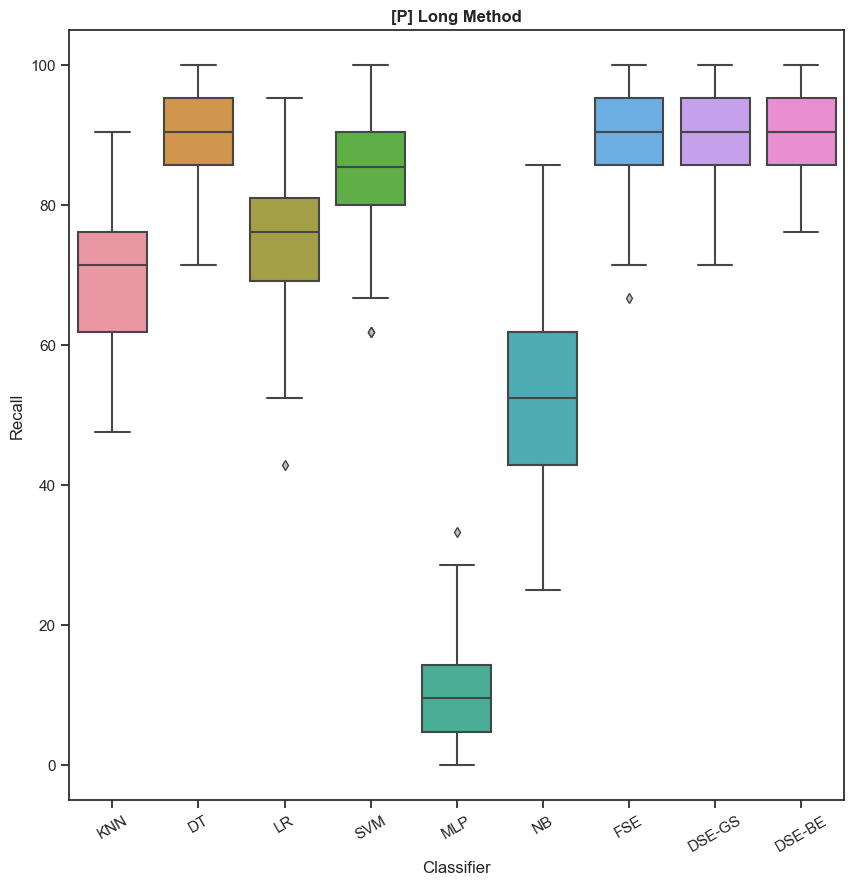

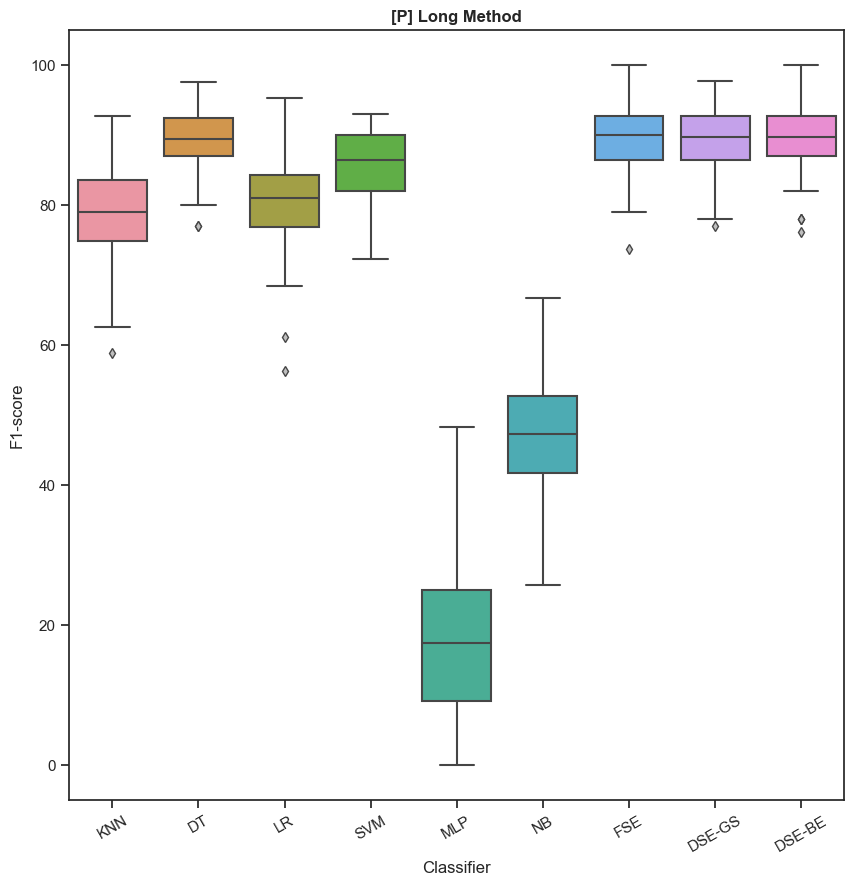

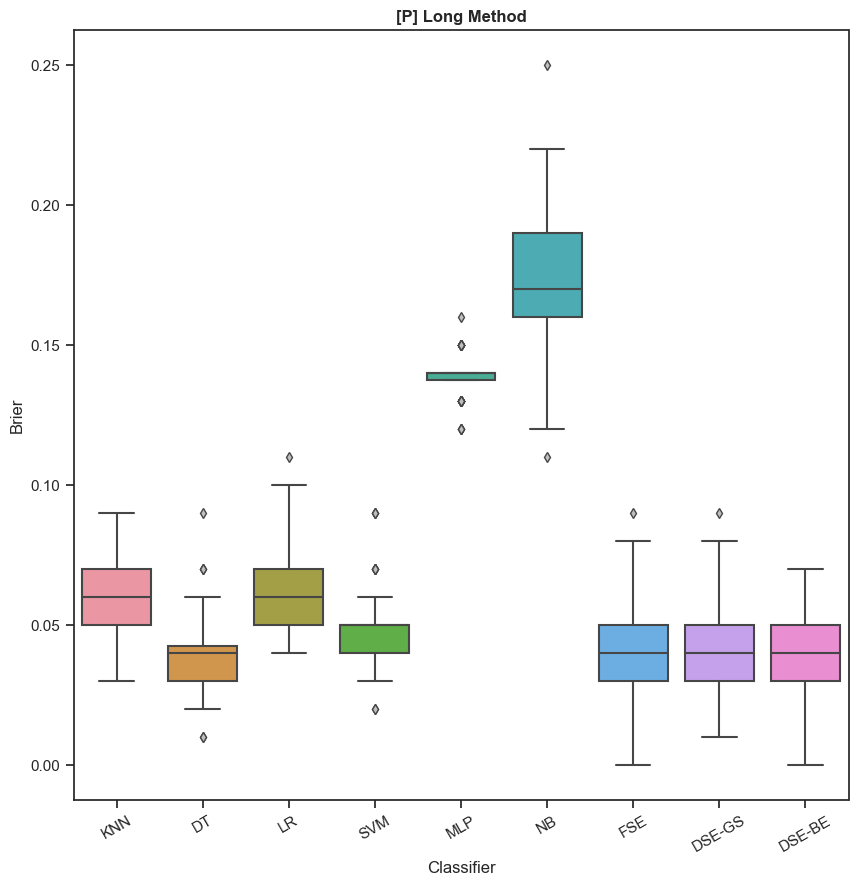

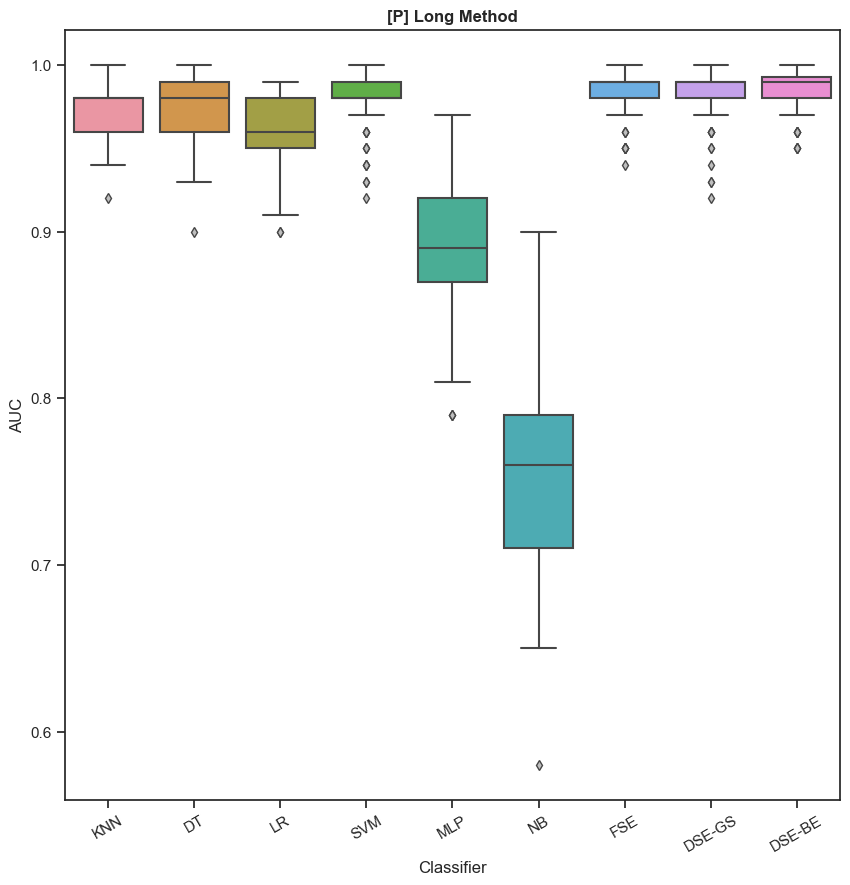

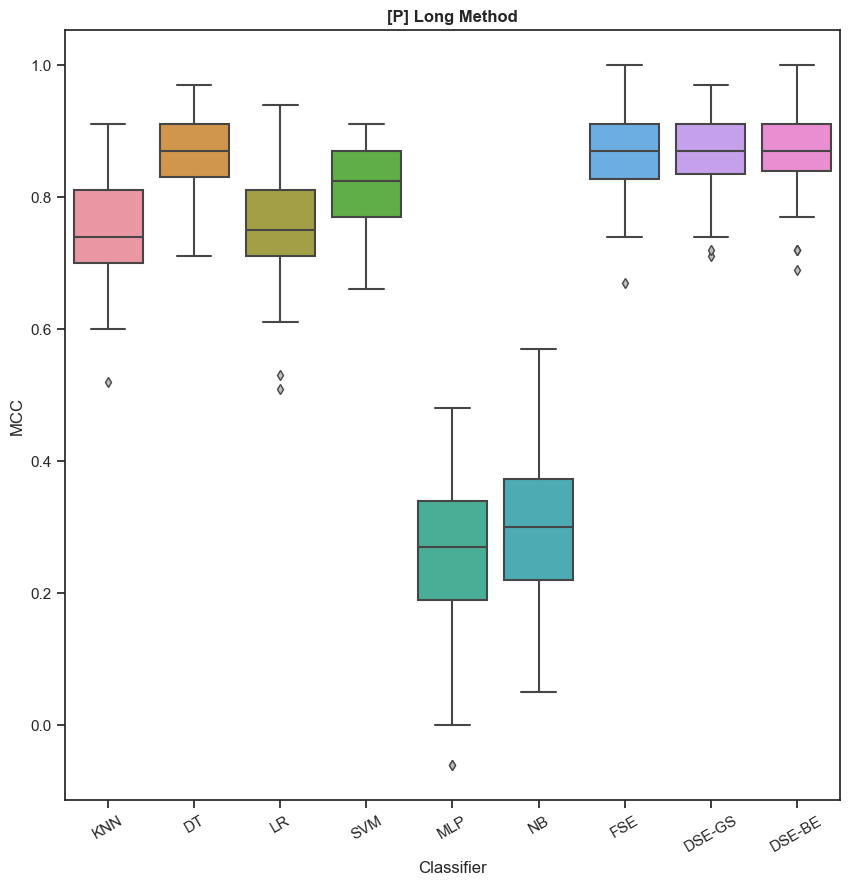

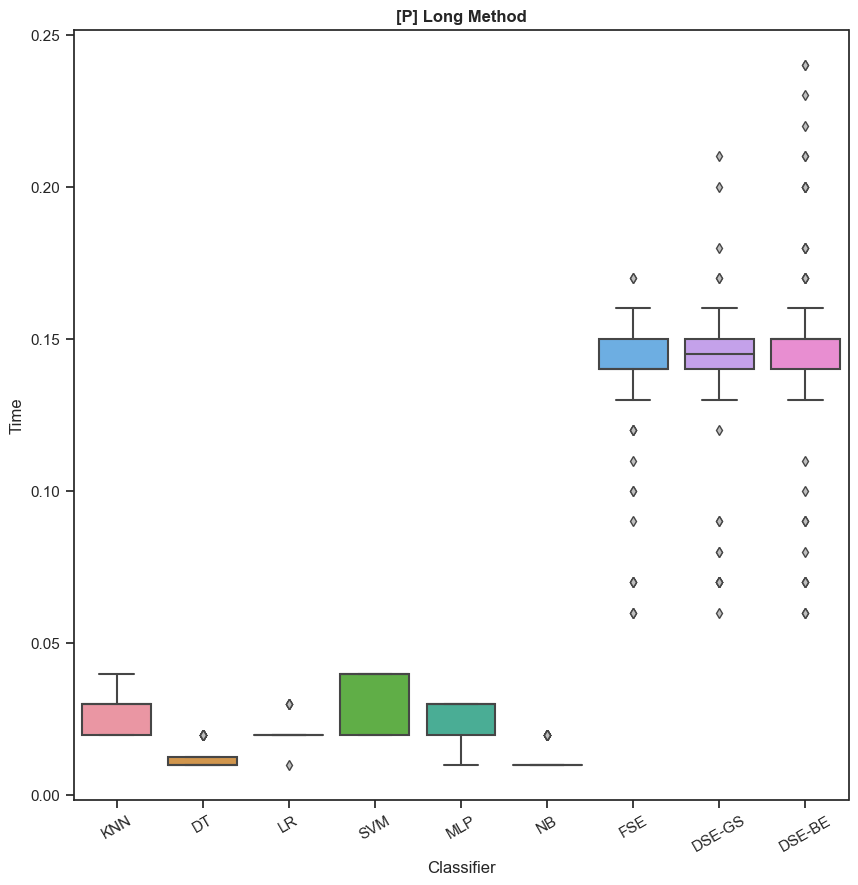

In [3]:
# sns.set(style='ticks', palette='Set3')
# sns.set(style='ticks', palette='Pastel1')
sns.set(style='ticks')
sns.set_palette("cubehelix")
# sns.set_palette("mako")


DetDF = pd.read_excel ('_DetailedResults.xlsx')
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Brier', 'AUC', 'MCC', 'Time']
# metrics = ['Accuracy', 'F1-score', 'Brier', 'AUC', 'MCC', 'Time']
# metrics = ['F1-score']


for fname in fnames:
  for metric in metrics:
    fname = fname.replace ('.csv','')
    f, ax = plt.subplots(figsize=(10, 10))
    flierprops = dict(markerfacecolor='0.75', markersize=5, linestyle='none')
    box = DetDF[DetDF['Dataset'] == fname]
    ax = sns.boxplot (x='Classifier',y=metric, data=box, flierprops=flierprops)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

    plt.ylabel (metric, size=12)
    plt.xlabel ('Classifier', size=12)
    plt.title (fname, fontweight='bold',size=12)
    plt.savefig( '_' + fname + '_' + metric + '_boxplot.png')
    plt.show()

In [4]:
names = DetDF['Classifier'].unique().tolist()

alpha = 0.05
alpha = alpha / (len(names)*(len(names)-1)/2)

for fname in fnames:
  for metric in metrics:
      fname = fname.replace ('.csv','')
      statDet = DetDF[DetDF['Dataset'] == fname]
      for i in range(len(names)):

        name = names[i]
        nestedNames = names[i+1:]

        for nested in nestedNames:

          model_1 =  statDet.loc[statDet['Classifier'] == name  ][metric]
          model_2 =  statDet.loc[statDet['Classifier'] == nested][metric]

          m1_score = model_1.mean()
          m2_score = model_2.mean()

          win, lost, effect_s, effect_t = '','','',''

          test = 'Wilcoxon'
          if m1_score == m2_score : stat, p = 1, 1
          else: stat, p = wilcoxon (model_1, model_2)

          if p > alpha: decision = 'Accept'
          else:
            decision = 'Reject'
            if   m1_score > m2_score : win, lost = name, nested
            else                     : win, lost = nested, name

            effect_s = stat / math.sqrt (len(model_1))
            if   effect_s < 0.3  : effect_t = 'small'
            elif effect_s < 0.5  : effect_t = 'moderate'
            elif effect_s >= 0.5 : effect_t = 'large'


          StaDF = StaDF.append({'Classifier_1' : name,
                                'Classifier_2' : nested,
                                'Test'         : test,
                                'Stat'         : stat,
                                'Sig-level'    : alpha,
                                'p-value'      : p,
                                'Null Hypo'    : decision,
                                'Win'          : win,
                                'Lost'         : lost,
                                'Effect Size'  : effect_s,
                                'Effect Type'  : effect_t,
                                'Dataset'      : fname,
                                'Metric'       : metric}
                              ,ignore_index=True)

StaDF.to_excel ('_StatisticalResults.xlsx', header='column_names')